In [4]:
import pandas as pd
import numpy as np
import matplotlib.backends.backend_tkagg
import matplotlib.pylab as plt
from astropy.io import fits
from astropy import units as units
import astropy.io.fits as pyfits
from astropy.convolution import Gaussian1DKernel, convolve
from extinction import calzetti00, apply, ccm89
from scipy import optimize
import sys
import time
import emcee
import corner
from multiprocessing import Pool,cpu_count
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
emcee.__version__

8 CPUs


'3.0.2'

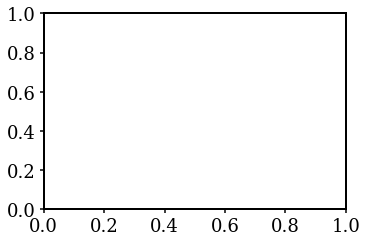

In [6]:
plt.tight_layout()
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=12, family='serif')
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=4)
plt.rc('ytick.major', width=1.5, size=4)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.subplots_adjust(bottom=0.2, left=0.2)

In [311]:
### Reading Spectra
df_cat=pd.read_csv('/Volumes/My Passport/goodss_3dhst_v4.1.5_catalogs/goodss_3dhst.v4.1.5.zbest.rf', delim_whitespace=True,header=None,comment='#',index_col=False)
df_cat.columns=["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153","L154","nfilt154", "L155", "nfilt155", "L161", "nfilt161", "L162", "nfilt162",\
                "L163", "nfilt163", "L156", "nfilt156", "L157", "nfilt157", "L158", "nfilt158", "L159", "nfilt159", "L160", "nfilt160", "L135", "nfilt135", "L136", "nfilt136",\
                "L137", "nfilt137", "L138", "nfilt138", "L139", "nfilt139", "L270", "nfilt270", "L271", "nfilt271", "L272", "nfilt272", "L273", "nfilt273", "L274", "nfilt274", "L275", "nfilt275"]

df = pd.read_csv('/Volumes/My Passport/TPAGB/database/matching_galaxies_goodss_20200303_PSB.csv', sep=',')

df.columns=['detector','ID','region','filename','chip']

df_photometry=pd.read_csv('/Volumes/My Passport/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat', delim_whitespace=True,header=None,comment='#',index_col=False)
df_photometry.columns=["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W", "f_F160W", "e_F160W", "w_F160W",\
                        "f_U38", "e_U38", "w_U38","f_U", "e_U", "w_U","f_F435W", "e_F435W", "w_F435W", "f_B", "e_B", "w_B", "f_V", "e_V", "w_V", \
                        "f_F606Wcand", "e_F606Wcand", "w_F606Wcand","f_F606W", "e_F606W","w_F606W","f_R", "e_R", "w_R", "f_Rc", "e_Rc", "w_Rc", \
                        "f_F775W", "e_F775W", "w_F775W","f_I", "e_I", "w_I", "f_F814Wcand", "e_F814Wcand", "w_F814Wcand", "f_F850LP", "e_F850LP", "w_F850LP",\
                        "f_F850LPcand", "e_F850LPcand", "w_F850LPcand", "f_F125W", "e_F125W", "w_F125W","f_J", "e_J", "w_J", "f_tenisJ", "e_tenisJ", "w_tenisJ",\
                        "f_F140W", "e_F140W", "w_F140W","f_H", "e_H", "w_H", "f_tenisK", "e_tenisK", "w_tenisK","f_Ks", "e_Ks", "w_Ks",\
                        "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2", "e_IRAC2", "w_IRAC2", "f_IRAC3", "e_IRAC3", "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4",\
                        "f_IA427", "e_IA427", "f_IA445", "e_IA445", "f_IA505", "e_IA505", "f_IA527", "e_IA527", "f_IA550", "e_IA550", "f_IA574", "e_IA574",\
                        "f_IA598", "e_IA598", "f_IA624", "e_IA624", "f_IA651", "e_IA651", "f_IA679", "e_IA679", "f_IA738", "e_IA738", "f_IA767", "e_IA767",\
                        "f_IA797", "e_IA797", "f_IA856", "e_IA856", "tot_cor", "wmin_ground", "wmin_hst","wmin_wfc3", "wmin_irac", "z_spec", "star_flag",\
                        "kron_radius","a_image", "b_image", "theta_J2000", "class_star", "flux_radius", "fwhm_image", "flags", "IRAC1_contam", "IRAC2_contam",\
                         "IRAC3_contam", "IRAC4_contam", "contam_flag","f140w_flag", "use_phot", "near_star", "nexp_f125w", "nexp_f140w", "nexp_f160w"]

df_fast = pd.read_csv('/Volumes/My Passport/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout', delim_whitespace=True,header=None,comment='#',index_col=False)
df_fast.columns = ['id', 'z', 'ltau', 'metal','lage','Av','lmass','lsfr','lssfr','la2t','chi2']

df_zfit = pd.read_csv('/Volumes/My Passport/goodss_3dhst_v4.1.5_catalogs/goodss_3dhst.v4.1.5.zfit.concat.dat',delim_whitespace=True,header=None,comment='#',index_col=False)
df_zfit.columns=['phot_id','grism_id','jh_mag','z_spec','z_peak_phot','z_phot_l95',\
                'z_phot_l68','z_phot_u68','z_phot_u95','z_max_grism','z_peak_grism',\
                'l95','l68','u68','u95','f_cover','f_flagged','max_contam','int_contam',\
                'f_negative','flag1','flag2']

In [9]:
# ###  Ma05
norm_wavelength= 5500.0
df_Ma = pd.read_csv('/Volumes/My Passport/M09_ssp_pickles.sed', delim_whitespace=True, header=None, comment='#',index_col=False)# only solar metallicity is contained in this catalogue
df_Ma.columns = ['Age','ZH','l','Flambda']
age = df_Ma.Age
metallicity = df_Ma.ZH
wavelength = df_Ma.l
Flux = df_Ma.Flambda
age_1Gyr_index = np.where(age==1.0)[0]
age_1Gyr = age[age_1Gyr_index]
metallicity_1Gyr = metallicity[age_1Gyr_index]
wavelength_1Gyr = wavelength[age_1Gyr_index]
Flux_1Gyr = Flux[age_1Gyr_index]
F_5500_1Gyr_index=np.where(wavelength_1Gyr==norm_wavelength)[0]
F_5500_1Gyr = Flux_1Gyr[wavelength_1Gyr==norm_wavelength].values # this is the band to be normalized 


df_M13 = pd.read_csv('/Volumes/My Passport/M13_models/sed_M13.ssz002',delim_whitespace=True,header=None,comment='#',index_col=False)
df_M13.columns = ['Age','ZH','l','Flambda']
age_M13 = df_M13.Age
metallicity_M13 = df_M13.ZH
wavelength_M13 = df_M13.l
Flux_M13 = df_M13.Flambda
age_1Gyr_index_M13 = np.where(age_M13==1.0)[0]#[0]
age_1Gyr_M13 = age_M13[age_1Gyr_index_M13]
metallicity_1Gyr_M13 = metallicity_M13[age_1Gyr_index_M13]
wavelength_1Gyr_M13 = wavelength_M13[age_1Gyr_index_M13]
Flux_1Gyr_M13 = Flux_M13[age_1Gyr_index_M13]
F_5500_1Gyr_index_M13=np.where(abs(wavelength_1Gyr_M13-norm_wavelength)<15)[0]
F_5500_1Gyr_M13 = 0.5*(Flux_1Gyr_M13.loc[62271+F_5500_1Gyr_index_M13[0]]+Flux_1Gyr_M13.loc[62271+F_5500_1Gyr_index_M13[1]])


# ### BC03
df_BC = pd.read_csv('/Volumes/My Passport/ssp_900Myr_z02.spec',delim_whitespace=True,header=None,comment='#',index_col=False)
df_BC.columns=['Lambda','Flux']
wavelength_BC = df_BC.Lambda
Flux_BC = df_BC.Flux
F_5500_BC_index=np.where(wavelength_BC==norm_wavelength)[0]
Flux_BC_norm = Flux_BC[F_5500_BC_index]

### Read in the BC03 models High-resolution, with Stelib library, Salpeter IMF, solar metallicity
BC03_fn='/Volumes/My Passport/bc03/models/Stelib_Atlas/Salpeter_IMF/bc2003_hr_stelib_m62_salp_ssp.ised_ASCII'
BC03_file = open(BC03_fn,"r")
BC03_X = []
for line in BC03_file:
    BC03_X.append(line)
BC03_SSP_m62 = np.array(BC03_X)
BC03_age_list = np.array(BC03_SSP_m62[0].split()[1:])
BC03_age_list_num = BC03_age_list.astype(np.float)/1.0e9 # unit is Gyr
BC03_wave_list = np.array(BC03_SSP_m62[6].split()[1:])
BC03_wave_list_num = BC03_wave_list.astype(np.float)
BC03_flux_list = np.array(BC03_SSP_m62[7:-12])
BC03_flux_array = np.zeros((221,7178))
for i in range(221):
    BC03_flux_array[i,:] = BC03_flux_list[i].split()[1:]
    BC03_flux_array[i,:] = BC03_flux_array[i,:]/BC03_flux_array[i,2556]# Normalize the flux


In [10]:
columns = ['ID','region','field',
          'M05_age_opt','M05_AV_opt','M13_age_opt','M13_AV_opt','BC_age_opt','BC_AV_opt',\
          'x2_spectra_M05_opt','x2_photo_M05_opt','x2_spectra_M13_opt','x2_photo_M13_opt','x2_spectra_BC_opt','x2_photo_BC_opt',\
          'M05_age_MCMC50','M05_age_std','M05_AV_MCMC50','M05_AV_std','M13_age_MCMC50','M13_age_std','M13_AV_MCMC50','M13_AV_std','BC_age_MCMC50','BC_age_std','BC_AV_MCMC50','BC_AV_std',\
          'x2_spectra_M05_MCMC50','x2_photo_M05_MCMC50','x2_spectra_M13_MCMC50','x2_photo_M13_MCMC50','x2_spectra_BC_MCMC50','x2_photo_BC_MCMC50',\
          'x2_M05_opt','x2_M13_opt','x2_BC_opt','x2_M05_MCMC50','x2_M13_MCMC50','x2_BC_MCMC50',\
          'model','grism_index','grism_index_AV_corr','age_opt','age_opt_std','AV_opt','AV_opt_std']
chi_square_list = pd.DataFrame(index=df.index,columns=columns)
chi_square_list_final = pd.DataFrame(index=df.index,columns=columns)

weight1 = 0.25#0.0#1/1.864#/0.5
weight2 = weight1*5e-3#1.0#1/1228.53#/0.5

In [313]:
def find_nearest(array,value):
    idx = np.argmin(np.abs(array-value))
    return idx
def read_spectra(row):
    """
    region: default 1 means the first region mentioned in the area, otherwise, the second region/third region
    """
    detector=df.detector[row]
    region = df.region[row]
    chip = df.chip[row]
    ID = df.ID[row]
    redshift_1=df_cat.loc[ID-1].z_best
    mag = -2.5*np.log10(df_cat.loc[ID-1].L161)+25#+0.02
    #print mag
    #WFC3 is using the infrared low-resolution grism, and here we are using the z band
    if detector == 'WFC3':
        filename="/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-"+"{0:02d}".format(region)+"/1D/ASCII/goodss-"+"{0:02d}".format(region)+"-G141_"+"{0:05d}".format(ID)+".1D.ascii"
        OneD_1 = np.loadtxt(filename,skiprows=1)
    if detector =="ACS":
        filename="/Volumes/My Passport/GOODSS_ACS_V4.1.5/acs-goodss-"+"{0:02d}".format(region)+"/1D/FITS/"+df.filename[row]
        OneD_1 = fits.getdata(filename, ext=1)
    return ID, OneD_1,redshift_1, mag
def reduced_chi_square(data_wave,data,data_err,model_wave,model):
    n=len(data_wave)
    chi_square = 0
    for i in range(n):
        index = find_nearest(model_wave,data_wave[i]);#print index
        chi_square += (data[i]-model[index])**2/(data_err[i]**2)
        # print('chisquare processes',i,chi_square,data[i],model[index],data_err[i])
    reduced_chi_square = chi_square/n
    return reduced_chi_square
def Lick_index_ratio(wave, flux, band=3):
    if band == 3:
        blue_min = 1.06e4  # 1.072e4#
        blue_max = 1.08e4  # 1.08e4#
        red_min = 1.12e4  # 1.097e4#
        red_max = 1.14e4  # 1.106e4#
        band_min = blue_max
        band_max = red_min


    # Blue
    blue_mask = (wave >= blue_min) & (wave <= blue_max)
    blue_wave = wave[blue_mask]
    blue_flux = flux[blue_mask]

    # Red
    red_mask = (wave >= red_min) & (wave <= red_max)
    red_wave = wave[red_mask]
    red_flux = flux[red_mask]

    band_mask = (wave >= band_min) & (wave <= band_max)
    band_wave = wave[band_mask]
    band_flux = flux[band_mask]

    if len(blue_wave) == len(red_wave) and len(blue_wave) != 0:
        ratio = np.mean(blue_flux) / np.mean(red_flux)
    elif red_wave == []:
        ratio = np.mean(blue_flux) / np.mean(red_flux)
    elif len(blue_wave) != 0 and len(red_wave) != 0:
        ratio = np.mean(blue_flux) / np.mean(red_flux)

    # ratio_err = np.sqrt(np.sum(1/red_flux**2*blue_flux_err**2)+np.sum((blue_flux/red_flux**2*red_flux_err)**2))

    return ratio  # , ratio_err
def binning_spec_keep_shape(wave,flux,bin_size):
    wave_binned = wave
    flux_binned = np.zeros(len(wave))
    for i in range((int(len(wave)/bin_size))+1):
        flux_binned[bin_size*i:bin_size*(i+1)] = np.mean(flux[bin_size*i:bin_size*(i+1)])
    return wave_binned, flux_binned#, flux_err_binned
def derive_1D_spectra_Av_corrected(OneD_1, redshift_1, rownumber, wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod, A_v):
    """
    OneD_1 is the oneD spectra
    redshift_1 is the redshift of the spectra
    rownumber is the row number in order to store the spectra
    """
    region = df.region[rownumber]
    ID = df.ID[rownumber]
    n = len(OneD_1)
    age =10**(df_fast.loc[ID-1].lage)/1e9 ## in Gyr
    metal = df_fast.loc[ID-1].metal
    sfr = 10**(df_fast.loc[ID-1].lsfr)
    intrinsic_Av = df_fast.loc[ID-1].Av   
    
    norm_factor_BC = int((OneD_1[int(n/2+1)][0]-OneD_1[int(n/2)][0])/(1+redshift_1)/1)
    norm_limit_BC = int(5930/norm_factor_BC)*norm_factor_BC+400
    smooth_wavelength_BC_1 = wavelength_BC[400:norm_limit_BC].values.reshape(-1,norm_factor_BC).mean(axis=1)
    smooth_wavelength_BC = np.hstack([smooth_wavelength_BC_1,wavelength_BC[norm_limit_BC:]])

    smooth_Flux_BC_1 = Flux_BC[400:norm_limit_BC].values.reshape(-1,norm_factor_BC).mean(axis=1)
    smooth_Flux_BC = np.hstack([smooth_Flux_BC_1,Flux_BC[norm_limit_BC:]])/Flux_BC_norm.values[0]
    
    norm_factor_Ma = int((OneD_1[int(n/2+1)][0]-OneD_1[int(n/2)][0])/(1+redshift_1)/5)
    norm_limit_Ma = int(4770/norm_factor_Ma)*norm_factor_Ma
    smooth_wavelength_Ma = wavelength_1Gyr[:norm_limit_Ma].values.reshape(-1,norm_factor_Ma).mean(axis=1)
    smooth_Flux_Ma_1Gyr = Flux_1Gyr[:norm_limit_Ma].values.reshape(-1,norm_factor_Ma).mean(axis=1)/F_5500_1Gyr

    # Normalize the flux
    if redshift_1<=0.1:
        i = 12
        temp_norm_wave = wave_list[i]#/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at IA574: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.2:
        i = 13
        temp_norm_wave = wave_list[i]#/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at IA624: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.3:
        i = 15
        temp_norm_wave = wave_list[i]#/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at IA679: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.4:
        i = 16
        temp_norm_wave = wave_list[i]#/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at IA738: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.5:
        i = 18
        temp_norm_wave = wave_list[i]#/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at IA797: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.6:
        i = 19
        temp_norm_wave = wave_list[i]#/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at IA856: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    else:
        i = 26
        temp_norm_wave = wave_list[i]#/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at F850LPcand: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    
    x = np.zeros(n)
    y = np.zeros(n)
    y_err = np.zeros(n)
    sensitivity = np.zeros(n)
    for i in range(0,n):
        x[i] = OneD_1[i][0]#/(1+redshift_1)
        
    spectra_extinction = calzetti00(x, A_v, 4.05)

    for i in range(n):
        spectra_flux_correction = 10**(0.4*spectra_extinction[i])# from obs to obtain the true value: the absolute value
        x[i] = x[i]/(1+redshift_1)
        y[i] = (OneD_1[i][1]-OneD_1[i][3])/OneD_1[i][6]*spectra_flux_correction#/Flux_0 # (flux-contamination)/sensitivity
        y_err[i] = OneD_1[i][2]/OneD_1[i][6]*spectra_flux_correction#/Flux_0
        sensitivity[i] = OneD_1[i][6]
    print(np.diff(sensitivity[263:282],1)[1:])
    end_index = np.argmin(np.diff(sensitivity[263:282],2)[1:],0)+263
    start_index = np.argmin(np.diff(sensitivity[40:50],2)[1:])+42

    print(start_index,end_index)
    plt.plot(x*(1+redshift_1),sensitivity,color='k')
    plt.plot(x[start_index:end_index]*(1+redshift_1),sensitivity[start_index:end_index],color='red')
    print('before masking',len(x))
    x = x[start_index:end_index]#[int(n*2/10):int(n*8/10)]
    y = y[start_index:end_index]*1e-17/norm_band#[int(n*2/10):int(n*8/10)]*1e-17/norm_band
    y_err = y_err[start_index:end_index]*1e-17/norm_band#[int(n*2/10):int(n*8/10)]*1e-17/norm_band
    print('after masking',len(x))
    
    mask_non_neg_photo = np.where(photometric_flux>0)
    wave_list = wave_list[mask_non_neg_photo]
    band_list = band_list[mask_non_neg_photo]
    photometric_flux = photometric_flux[mask_non_neg_photo]
    photometric_flux_err = photometric_flux_err[mask_non_neg_photo]
    photometric_flux_err_mod = photometric_flux_err_mod[mask_non_neg_photo]

    return x, y, y_err, wave_list/(1+redshift_1), band_list/(1+redshift_1), photometric_flux/norm_band, photometric_flux_err/norm_band, photometric_flux_err_mod/norm_band        
def model_identification(chi2_array,rtol=0.1):
    index = find_nearest(chi2_array,1)    
    model = np.mod(index,3)+1
    chi2_array_comp = abs(chi2_array-1)
    chi2_array_comp_idx = np.argsort(chi2_array_comp)[:2]
    if np.mod(chi2_array_comp_idx[0],3)==np.mod(chi2_array_comp_idx[1],3):
        chi2_array_comp_idx = np.argsort(chi2_array_comp)[1:3]
    chi2_min2_array = chi2_array[chi2_array_comp_idx]
    if np.isclose(chi2_min2_array[0],chi2_min2_array[1],rtol=rtol):
        model = 0
    return model
def model_from_chi2(df_opt):
    for i in range(len(df_opt)):
        chi2_array=df_opt.loc[i,['x2_M05_opt','x2_M13_opt','x2_BC_opt',\
                                 'x2_M05_MCMC50','x2_M13_MCMC50','x2_BC_MCMC50']].values
        chi2_spec_array=df_opt.loc[i,['x2_spectra_M05_opt','x2_spectra_M13_opt','x2_spectra_BC_opt',\
                                      'x2_spectra_M05_MCMC50','x2_spectra_M13_MCMC50','x2_spectra_BC_MCMC50']].values
        chi2_phot_array=df_opt.loc[i,['x2_photo_M05_opt','x2_photo_M13_opt','x2_photo_BC_opt',\
                                      'x2_photo_M05_MCMC50','x2_photo_M13_MCMC50','x2_photo_BC_MCMC50']].values
        age_array=df_opt.loc[i,['M05_age_opt','M13_age_opt','BC_age_opt',\
                                'M05_age_MCMC50','M13_age_MCMC50','BC_age_MCMC50']].values
        age_std_array=df_opt.loc[i,['M05_age_std','M13_age_std','BC_age_std',\
                                    'M05_age_std','M13_age_std','BC_age_std']].values
        AV_array=df_opt.loc[i,['M05_AV_opt','M13_AV_opt','BC_AV_opt',\
                               'M05_AV_MCMC50','M13_AV_MCMC50','BC_AV_MCMC50']].values
        AV_std_array=df_opt.loc[i,['M05_AV_std','M13_AV_std','BC_AV_std',\
                                   'M05_AV_std','M13_AV_std','BC_AV_std']].values        
        index = find_nearest(chi2_array,0)    
        df_opt.loc[i,'model'] = np.mod(index,3)+1
        df_opt.loc[i,'model_new']=model_identification(chi2_array)
        df_opt.loc[i,'best_chi2']=chi2_array[index]
        df_opt.loc[i,'best_chi2_spec']=chi2_spec_array[index]
        df_opt.loc[i,'best_chi2_phot']=chi2_phot_array[index]
        df_opt.loc[i,'age_opt']=age_array[index]
        df_opt.loc[i,'age_opt_std']=age_std_array[index]
        df_opt.loc[i,'AV_opt']=AV_array[index]
        df_opt.loc[i,'AV_opt_std']=AV_std_array[index]
    return df_opt

In [131]:
def binning_spec_keep_shape_x(wave,flux,flux_err,bin_size):
    wave_binned = wave
    flux_binned = np.zeros(len(wave))
    flux_err_binned = np.zeros(len(wave))
    for i in range((int(len(wave)/bin_size))+1):
        flux_binned[bin_size*i:bin_size*(i+1)] = np.mean(flux[bin_size*i:bin_size*(i+1)])
        flux_err_binned[bin_size*i:bin_size*(i+1)] = np.mean(flux_err[bin_size*i:bin_size*(i+1)])
    return wave_binned, flux_binned, flux_err_binned
def minimize_age_AV_vector_weighted(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]

    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model1 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            model1 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            model1 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            model1 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            model1 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            model1 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            model1 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            model1 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            model1 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            model1 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            model1 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            model1 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            model1 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_15_Av_00_z002.csv'
            model1 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model1 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new

    # print('Age',galaxy_age, age_prior)
    binning_index = find_nearest(model1[0,:],np.median(x));
    if (x[int(n/2)]-x[int(n/2)-1]) > (model1[0,binning_index]-model1[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model1[0,binning_index]-model1[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new, binning_size)
        # print('model flux before binning:',smooth_Flux_Ma_1Gyr_new)
        # print('binned model flux', model_flux_binned)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    else:
        binning_size = int((model1[0,binning_index]-model1[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model1[0,:], smooth_Flux_Ma_1Gyr_new) 
        # print('binning data, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model1[0,:], smooth_Flux_Ma_1Gyr_new)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo
def lg_minimize_age_AV_vector_weighted(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model1 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            model1 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            model1 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            model1 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            model1 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            model1 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            model1 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            model1 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            model1 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            model1 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            model1 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            model1 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            model1 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_15_Av_00_z002.csv'
            model1 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model1 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new

    binning_index = find_nearest(model1[0,:],np.median(x));
    if (x[int(n/2)]-x[int(n/2)-1]) > (model1[0,binning_index]-model1[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model1[0,binning_index]-model1[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    else:
        binning_size = int((model1[0,binning_index]-model1[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model1[0,:], smooth_Flux_Ma_1Gyr_new) 
        # print('binning data, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model1[0,:], smooth_Flux_Ma_1Gyr_new)
    
    if 0.01<galaxy_age<13.0 and 0.0<intrinsic_Av<4.0 and not np.isinf(x2+1e-3*x2_photo):
        return np.log(np.exp(-0.5*(0.5*weight1*x2+0.5*weight2*x2_photo)))
    else:
        return -np.inf
def minimize_age_AV_vector_weighted_return_flux(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    #print('galaxy age', galaxy_age, 'age prior:', age_prior)
    AV_string = str(intrinsic_Av)
    #print('intrinsic Av:', intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model1 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age <= 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_15_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model1 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new

    binning_index = find_nearest(model1[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model1[0,binning_index]-model1[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model1[0,binning_index]-model1[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    else:
        binning_size = int((model1[0,binning_index]-model1[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model1[0,:], smooth_Flux_Ma_1Gyr_new) 
        # print('binning data, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size) 
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model1[0,:], smooth_Flux_Ma_1Gyr_new)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo, model1[0,:], smooth_Flux_Ma_1Gyr_new
def minimize_age_AV_vector_weighted_return_chi2_sep(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    #print('galaxy age', galaxy_age, 'age prior:', age_prior)
    AV_string = str(intrinsic_Av)
    #print('intrinsic Av:', intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model1 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_15_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model1 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new
    
    binning_index = find_nearest(model1[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model1[0,binning_index]-model1[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model1[0,binning_index]-model1[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    else:
        binning_size = int((model1[0,binning_index]-model1[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model1[0,:], smooth_Flux_Ma_1Gyr_new) 
        # print('binning data, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size) 
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model1[0,:], smooth_Flux_Ma_1Gyr_new)
    
    return x2,x2_photo

def minimize_age_AV_vector_weighted_M13(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_0001_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior < 1 and age_prior>=1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            model2 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            model2 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            model2 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            model2 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            model2 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            model2 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            model2 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            model2 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            model2 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            model2 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            model2 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            model2 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_15_Av_00_z002.csv'
            model2 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model2 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new

    binning_index = find_nearest(model2[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model2[0,binning_index]-model2[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model2[0,binning_index]-model2[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    else:
        binning_size = int((model2[0,binning_index]-model2[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model2[0,:], smooth_Flux_M13_1Gyr_new) 
        # print('binning data, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model2[0,:], smooth_Flux_M13_1Gyr_new)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo
def lg_minimize_age_AV_vector_weighted_M13(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_0001_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior < 1 and age_prior>=1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            model2 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            model2 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            model2 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            model2 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            model2 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            model2 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            model2 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            model2 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            model2 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            model2 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            model2 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            model2 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_15_Av_00_z002.csv'
            model2 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model2 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new
    
    binning_index = find_nearest(model2[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model2[0,binning_index]-model2[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model2[0,binning_index]-model2[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    else:
        binning_size = int((model2[0,binning_index]-model2[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model2[0,:], smooth_Flux_M13_1Gyr_new) 
        # print('binning data, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    

    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model2[0,:], smooth_Flux_M13_1Gyr_new)
    
    if 0.01<galaxy_age<13 and 0.0<intrinsic_Av<4.0 and not np.isinf(0.5*x2+0.5*1e-3*x2_photo):
        return np.log(np.exp(-0.5*(0.5*weight1*x2+0.5*weight2*x2_photo)))
    else:
        return -np.inf
def minimize_age_AV_vector_weighted_M13_return_flux(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_0001_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior < 1 and age_prior>=1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            model2 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            model2 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            model2 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            model2 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            model2 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            model2 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            model2 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            model2 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            model2 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            model2 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            model2 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            model2 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_15_Av_00_z002.csv'
            model2 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model2 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new

    binning_index = find_nearest(model2[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model2[0,binning_index]-model2[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model2[0,binning_index]-model2[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    else:
        binning_size = int((model2[0,binning_index]-model2[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model2[0,:], smooth_Flux_M13_1Gyr_new) 
        # print('binning data, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    

    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model2[0,:], smooth_Flux_M13_1Gyr_new)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo, model2[0,:], smooth_Flux_M13_1Gyr_new
def minimize_age_AV_vector_weighted_M13_return_chi2_sep(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_0001_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior < 1 and age_prior>=1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            model2 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            model2 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            model2 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            model2 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            model2 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            model2 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            model2 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            model2 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            model2 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            model2 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            model2 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            model2 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_15_Av_00_z002.csv'
            model2 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model2 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new

    binning_index = find_nearest(model2[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model2[0,binning_index]-model2[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model2[0,binning_index]-model2[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    else:
        binning_size = int((model2[0,binning_index]-model2[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model2[0,:], smooth_Flux_M13_1Gyr_new) 
        # print('binning data, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
 
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model2[0,:], smooth_Flux_M13_1Gyr_new)
    
    return x2, x2_photo

def minimize_age_AV_vector_weighted_BC03(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)
    print(galaxy_age,age_prior)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval
    elif galaxy_age > age_prior:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval   

    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    # print('BC x2_nu',x2,x2_photo,0.5*weight1*x2+0.5*weight2*x2_photo)
    return 0.5*weight1*x2+0.5*weight2*x2_photo
def lg_minimize_age_AV_vector_weighted_BC03(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval
    elif galaxy_age > age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval   
    else:
        model3_flux = BC03_flux_array[-1, :7125]   
    
    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    if 0.01<galaxy_age<13 and 0.0<intrinsic_Av<4.0 and not np.isinf(0.5*x2+0.5*1e-3*x2_photo):
        return np.log(np.exp(-0.5*(0.5*weight1*x2+0.5*weight2*x2_photo)))
    else:
        return -np.inf
def minimize_age_AV_vector_weighted_BC03_mod_no_weight_return_flux(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index-1, :7125]*(BC03_age_list_num[age_index]-galaxy_age)\
                            + BC03_flux_array[age_index, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval
    elif galaxy_age > age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age)\
                            + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval   

    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)     
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo,BC03_flux_attenuated
def minimize_age_AV_vector_weighted_BC03_return_chi2_sep(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval
    elif galaxy_age > age_prior:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval   

    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    return x2,x2_photo
def minimize_age_AV_vector_weighted_BC03_mod(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index-1, :7125]*(BC03_age_list_num[age_index]-galaxy_age)\
                    + BC03_flux_array[age_index, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval
    elif galaxy_age > age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age)\
                    + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval   

    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo
def lg_minimize_age_AV_vector_weighted_return_BC03_mod(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index-1, :7125]*(BC03_age_list_num[age_index]-galaxy_age)\
                    + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval
    elif galaxy_age > age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age)\
                    + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval   
    else:
        model3_flux = BC03_flux_array[-1, :7125]   
    
    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    if 0.01<galaxy_age<13 and 0.0<intrinsic_Av<4.0 and not np.isinf(0.5*x2+0.5*1e-3*x2_photo):
        return np.log(np.exp(-0.5*(0.5*weight1*x2+0.5*weight2*x2_photo)))
    else:
        return -np.inf


### 0 Preparation

0 21832
intrinsic Av:0.2
Galaxy age: 3.1622776601683795
[-0.013259  -0.0110485 -0.0096544 -0.0085723 -0.0075665 -0.0068185
 -0.0056618 -0.0041847 -0.0072883 -0.0152261 -0.0274676 -0.046768
 -0.0692485 -0.0985589 -0.1254631 -0.153322  -0.1772907]
42 275
before masking 312
after masking 233
1 45975
intrinsic Av:0.2
Galaxy age: 5.011872336272715
[-0.0052959 -0.0042609 -0.0106574 -0.0184502 -0.0361038 -0.0551262
 -0.0835419 -0.1121582 -0.1408379 -0.1688711 -0.1910218 -0.2122052
 -0.222694  -0.2325425 -0.2303867 -0.2275154 -0.2099225]
42 270
before masking 312
after masking 228
2 46274
intrinsic Av:0.2
Galaxy age: 5.011872336272715
[-0.004337  -0.0073249 -0.0155776 -0.0282951 -0.0482506 -0.0719403
 -0.102171  -0.1301917 -0.1590414 -0.1833937 -0.2049958 -0.219687
 -0.2295157 -0.2320204 -0.2294738 -0.2172595 -0.1997892]
43 268
before masking 312
after masking 225
3 46500
intrinsic Av:0.4
Galaxy age: 1.9952623149688828
[-0.0041825 -0.0085654 -0.016441  -0.0311663 -0.0505276 -0.0761151
 -0.1056

30 12009
intrinsic Av:0.1
Galaxy age: 5.011872336272715
[-0.0060495 -0.0044928 -0.006616  -0.0150862 -0.0266837 -0.047086
 -0.0698185 -0.1006201 -0.1287338 -0.1578901 -0.1829456 -0.2046267
 -0.2203059 -0.2300214 -0.2334059 -0.2306672 -0.2192192]
42 269
before masking 312
after masking 227
31 14729
intrinsic Av:0.1
Galaxy age: 1.9952623149688828
[-0.0070904 -0.0059589 -0.0044151 -0.0068491 -0.0152214 -0.0271383
 -0.0473142 -0.0702228 -0.1007072 -0.1286371 -0.1575541 -0.1822949
 -0.2038334 -0.2192307 -0.2289038 -0.2321629 -0.2294617]
42 270
before masking 312
after masking 228
32 16493
intrinsic Av:0.2
Galaxy age: 3.1622776601683795
[-0.0136714 -0.0116316 -0.0099603 -0.0088856 -0.0077895 -0.0070372
 -0.0061747 -0.0047935 -0.0042795 -0.0111606 -0.0184578 -0.0357711
 -0.0533103 -0.0801386 -0.1066312 -0.133261  -0.1594752]
42 275
before masking 312
after masking 233
33 16716
intrinsic Av:0.1
Galaxy age: 5.011872336272715
[-0.0113536 -0.0136607 -0.0150056 -0.0139787 -0.0132382 -0.0110563
 -0

59 23102
intrinsic Av:0.4
Galaxy age: 3.1622776601683795
[-0.009005  -0.0078832 -0.0071245 -0.0060968 -0.0045823 -0.0056666
 -0.0139254 -0.0236343 -0.043611  -0.0639539 -0.0941748 -0.1214265
 -0.1498694 -0.1756396 -0.1964798 -0.2146714 -0.2234364]
42 272
before masking 312
after masking 230
60 23237
intrinsic Av:0.1
Galaxy age: 5.011872336272715
[-0.0203974 -0.0399589 -0.0601364 -0.0910281 -0.1203731 -0.1504629
 -0.1788036 -0.2012166 -0.2217737 -0.2314125 -0.239785  -0.2361727
 -0.2302103 -0.2104807 -0.1909962 -0.1631854 -0.1389927]
42 265
before masking 312
after masking 223
61 25053
intrinsic Av:0.3
Galaxy age: 5.011872336272715
[-0.0397923 -0.0598807 -0.0906399 -0.1198987 -0.1498832 -0.1781735
 -0.2005297 -0.2211136 -0.2307496 -0.2392295 -0.2356485 -0.229923
 -0.210255  -0.1910026 -0.1632565 -0.139118  -0.1152809]
42 264
before masking 312
after masking 222
62 25884
intrinsic Av:0.1
Galaxy age: 3.981071705534969
[-0.0340401 -0.0540802 -0.0822846 -0.1126103 -0.1423986 -0.1718867
 -0.

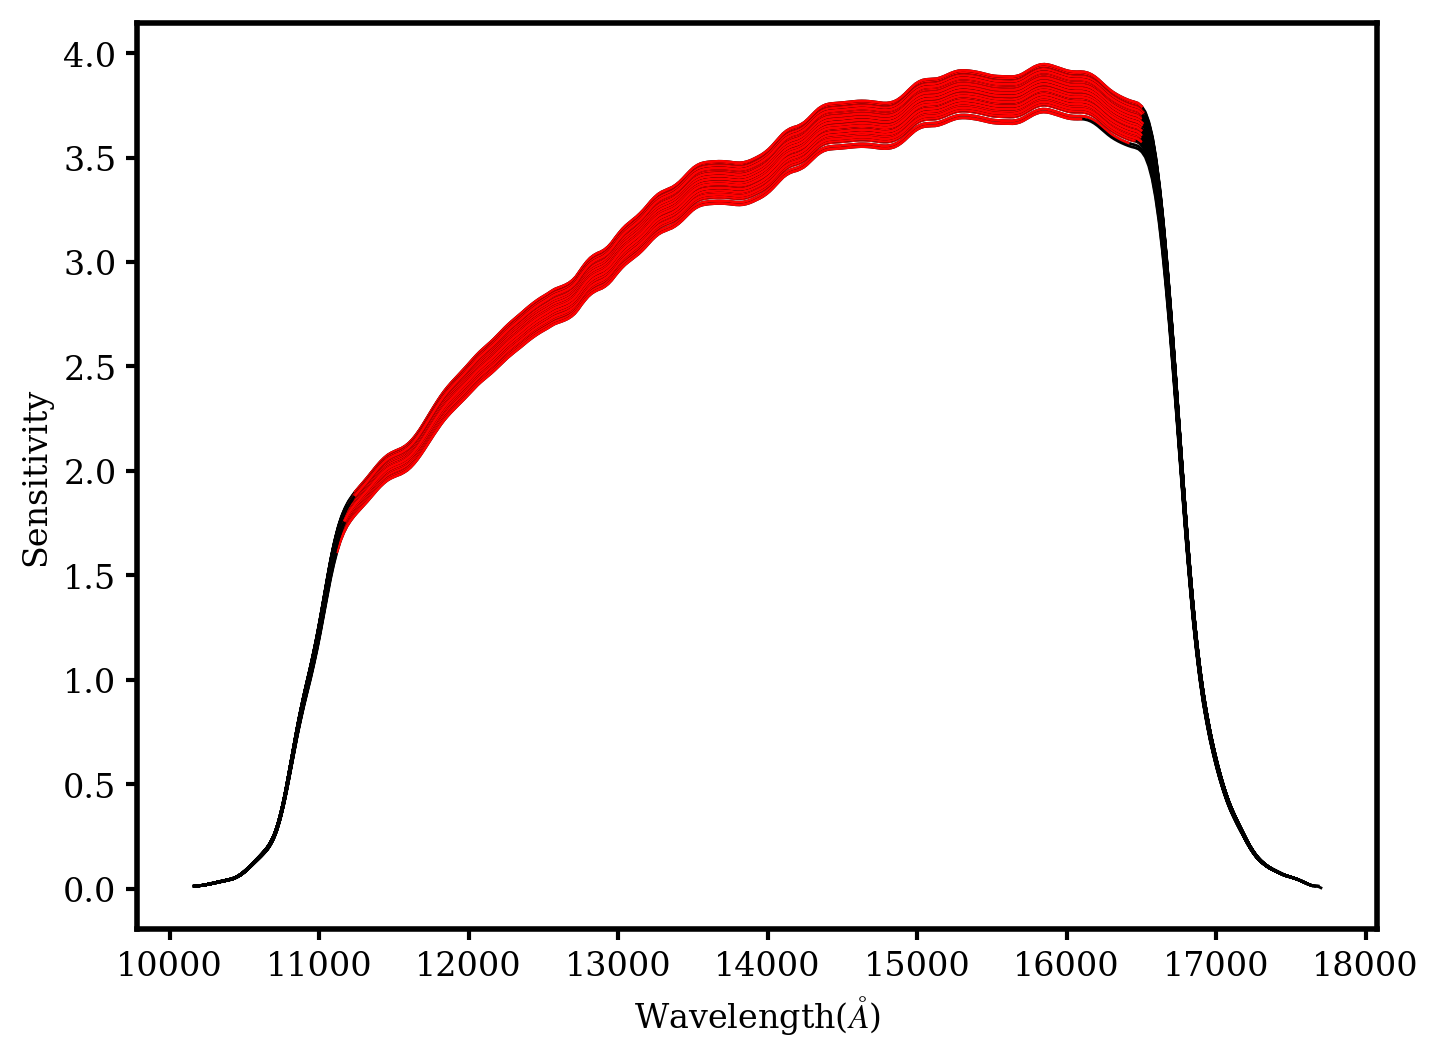

In [315]:
plt.figure(figsize=(8,6),dpi=200)
for i in range(83):
    row = i
    ##
    [ID, OneD_1, redshift_1, mag_1] = read_spectra(row)
    print(i, ID)        
    ID_no = ID-1
    redshift = df_photometry.loc[ID_no].z_spec

    region = df.region[row]
    intrinsic_Av = df_fast.loc[ID-1].Av
    print('intrinsic Av:'+str(intrinsic_Av))
    galaxy_age = 10**(df_fast.loc[ID-1].lage)/1e9
    print('Galaxy age:', galaxy_age)
    A_v=0.0207    
    c=3e10

    chi_square_list.loc[row,'ID'] = float(ID)
    chi_square_list.loc[row,'region'] = region
    chi_square_list.loc[row,'field'] = 'goodss'
    # Photometry
    # ESO GOODS  |  Nonino et al. 2009
    # Paranal_VIMOS U and VIMOS R
    U_wave = 3722
    U_band = 375.5/2.
    U = df_photometry.loc[ID_no].f_U/((U_wave)**2)*c*1e8*3.63e-30
    U_err = df_photometry.loc[ID_no].e_U/((U_wave)**2)*c*1e8*3.63e-30

    R_wave = 6449.7
    R_band = 1286.3/2.
    R = df_photometry.loc[ID_no].f_R/((R_wave)**2)*c*1e8*3.63e-30
    R_err = df_photometry.loc[ID_no].e_R/((R_wave)**2)*c*1e8*3.63e-30


    #  GaBoDs     | Hildebrandt et al. 2006, Erben 2005      
    # LaSilla WFI ESO 841-845.dat
    U38_wave = 3706 # ESO 841
    U38_band = 357./2.
    U38 = df_photometry.loc[ID_no].f_U38/((U38_wave)**2)*c*1e8*3.63e-30
    U38_err = df_photometry.loc[ID_no].e_U38/((U38_wave)**2)*c*1e8*3.63e-30

    B_wave = 4554 # 842
    B_band = 915./2.
    B = df_photometry.loc[ID_no].f_B/((B_wave)**2)*c*1e8*3.63e-30
    B_err = df_photometry.loc[ID_no].e_B/((B_wave)**2)*c*1e8*3.63e-30

    V_wave = 5343 #843
    V_band = 900./2.
    V = df_photometry.loc[ID_no].f_V/((V_wave)**2)*c*1e8*3.63e-30
    V_err = df_photometry.loc[ID_no].e_V/((V_wave)**2)*c*1e8*3.63e-30

    Rc_wave = 6411 #844
    Rc_band = 1602./2.
    Rc = df_photometry.loc[ID_no].f_Rc/((Rc_wave)**2)*c*1e8*3.63e-30
    Rc_err = df_photometry.loc[ID_no].e_Rc/((Rc_wave)**2)*c*1e8*3.63e-30

    I_wave = 8554 # 845
    I_band = 1504./2.
    I = df_photometry.loc[ID_no].f_I/((I_wave)**2)*c*1e8*3.63e-30
    I_err = df_photometry.loc[ID_no].e_I/((I_wave)**2)*c*1e8*3.63e-30


    # MUSYC      | Cardamone et al. 2010                 
    #f_IA427 e_IA427 f_IA445 e_IA445 f_IA505 e_IA505 f_IA527 e_IA527 f_IA550 e_IA550 f_IA574 
    #e_IA574 f_IA598 e_IA598 f_IA624 e_IA624 f_IA651 e_IA651 f_IA679 e_IA679 f_IA738 e_IA738 
    #f_IA767 e_IA767 f_IA797 e_IA797 f_IA856 e_IA856 
    # IA427: 4253, IA445: 4445, IA464: 4631, IA484: 4843, IA505: 5059, IA527: 5256, IA550: 5492, IA574: 5760
    # IA598: 6003, IA624: 6227, IA651: 6491, IA679: 6778, IA709: 7070, IA738: 7356, IA768: 7676, IA797: 7962
    # IA827:8243, IA856:8562
    IA427_wave = 4253
    IA427_band = 210./2.
    IA427 = df_photometry.loc[ID_no].f_IA427/IA427_wave**2*c*1e8*3.63e-30
    IA427_err = df_photometry.loc[ID_no].e_IA427/IA427_wave**2*c*1e8*3.63e-30

    IA445_wave = 4445
    IA445_band = 204./2.
    IA445 = df_photometry.loc[ID_no].f_IA445/IA445_wave**2*c*1e8*3.63e-30
    IA445_err = df_photometry.loc[ID_no].e_IA427/IA445_wave**2*c*1e8*3.63e-30

    IA505_wave = 5059
    IA505_band = 234./2.
    IA505 = df_photometry.loc[ID_no].f_IA505/IA505_wave**2*c*1e8*3.63e-30
    IA505_err = df_photometry.loc[ID_no].e_IA505/IA505_wave**2*c*1e8*3.63e-30

    IA527_wave = 5256
    IA527_band = 243./2.
    IA527 = df_photometry.loc[ID_no].f_IA527/IA527_wave**2*c*1e8*3.63e-30
    IA527_err = df_photometry.loc[ID_no].e_IA527/IA527_wave**2*c*1e8*3.63e-30

    IA550_wave = 5492
    IA550_band = 276./2.
    IA550 = df_photometry.loc[ID_no].f_IA550/IA550_wave**2*c*1e8*3.63e-30
    IA550_err = df_photometry.loc[ID_no].e_IA550/IA550_wave**2*c*1e8*3.63e-30

    IA574_wave = 5760
    IA574_band = 276./2.
    IA574 = df_photometry.loc[ID_no].f_IA574/IA574_wave**2*c*1e8*3.63e-30
    IA574_err = df_photometry.loc[ID_no].e_IA574/IA574_wave**2*c*1e8*3.63e-30

    IA598_wave = 6003
    IA598_band = 297./2.
    IA598 = df_photometry.loc[ID_no].f_IA598/IA598_wave**2*c*1e8*3.63e-30
    IA598_err = df_photometry.loc[ID_no].e_IA598/IA598_wave**2*c*1e8*3.63e-30

    IA624_wave = 6227
    IA624_band = 300./2.
    IA624 = df_photometry.loc[ID_no].f_IA624/IA624_wave**2*c*1e8*3.63e-30
    IA624_err = df_photometry.loc[ID_no].e_IA624/IA624_wave**2*c*1e8*3.63e-30

    IA651_wave = 6491
    IA651_band = 324./2.
    IA651 = df_photometry.loc[ID_no].f_IA651/IA651_wave**2*c*1e8*3.63e-30
    IA651_err = df_photometry.loc[ID_no].e_IA651/IA651_wave**2*c*1e8*3.63e-30

    IA679_wave = 6778
    IA679_band = 339./2.
    IA679 = df_photometry.loc[ID_no].f_IA679/IA679_wave**2*c*1e8*3.63e-30
    IA679_err = df_photometry.loc[ID_no].e_IA679/IA679_wave**2*c*1e8*3.63e-30

    IA738_wave = 7356
    IA738_band = 324./2.
    IA738 = df_photometry.loc[ID_no].f_IA738/IA738_wave**2*c*1e8*3.63e-30
    IA738_err = df_photometry.loc[ID_no].e_IA738/IA738_wave**2*c*1e8*3.63e-30

    IA767_wave = 7676
    IA767_band = 366./2.
    IA767 = df_photometry.loc[ID_no].f_IA767/IA767_wave**2*c*1e8*3.63e-30
    IA767_err = df_photometry.loc[ID_no].e_IA767/IA767_wave**2*c*1e8*3.63e-30

    IA797_wave = 7962
    IA797_band = 354./2.
    IA797 = df_photometry.loc[ID_no].f_IA797/IA797_wave**2*c*1e8*3.63e-30
    IA797_err = df_photometry.loc[ID_no].e_IA797/IA797_wave**2*c*1e8*3.63e-30

    IA856_wave = 8562
    IA856_band = 324./2.
    IA856 = df_photometry.loc[ID_no].f_IA856/IA856_wave**2*c*1e8*3.63e-30
    IA856_err = df_photometry.loc[ID_no].e_IA856/IA856_wave**2*c*1e8*3.63e-30

    # GOODS      |Giavalisco et al. 2004 | F435W,  F606W, F775W, F850LP|
    # https://uknowledge.uky.edu/cgi/viewcontent.cgi?referer=&httpsredir=1&article=1264&context=physastron_facpub
    # Also on Guo et al. 2013
    F435W_wave = 4317
    F435W_band = 920./2.
    F435W = df_photometry.loc[ID_no].f_F435W/((F435W_wave)**2)*c*1e8*3.63e-30
    F435W_err = df_photometry.loc[ID_no].e_F435W/((F435W_wave)**2)*c*1e8*3.63e-30

    F606W_wave = 5918
    F606W_band = 2324./2.
    F606W = df_photometry.loc[ID_no].f_F606W/((F606W_wave)**2)*c*1e8*3.63e-30
    F606W_err = df_photometry.loc[ID_no].e_F606W/((F606W_wave)**2)*c*1e8*3.63e-30

    F775W_wave = 7693
    F775W_band = 1511./2.
    F775W = df_photometry.loc[ID_no].f_F775W/((F775W_wave)**2)*c*1e8*3.63e-30
    F775W_err = df_photometry.loc[ID_no].e_F775W/((F775W_wave)**2)*c*1e8*3.63e-30

    F850LP_wave = 9055
    F850LP_band = 1236./2.
    F850LP = df_photometry.loc[ID_no].f_F850LP/((F850LP_wave)**2)*c*1e8*3.63e-30
    F850LP_err = df_photometry.loc[ID_no].e_F850LP/((F850LP_wave)**2)*c*1e8*3.63e-30


    # CANDELS    | Koekemoer et al. 2011, what wavelength this should take? : the same as above        
    F606Wcand_wave = 5918
    F606Wcand_band = 2324./2.
    F606Wcand = df_photometry.loc[ID_no].f_F606Wcand/((F606Wcand_wave)**2)*c*1e8*3.63e-30
    F606Wcand_err = df_photometry.loc[ID_no].e_F606Wcand/((F606Wcand_wave)**2)*c*1e8*3.63e-30

    F814Wcand_wave = 8047
    F814Wcand_band = 1826./2.
    F814Wcand = df_photometry.loc[ID_no].f_F814Wcand/((F814Wcand_wave)**2)*c*1e8*3.63e-30
    F814Wcand_err = df_photometry.loc[ID_no].e_F814Wcand/((F814Wcand_wave)**2)*c*1e8*3.63e-30

    F850LPcand_wave = 9055
    F850LPcand_band = 1236./2.
    F850LPcand = df_photometry.loc[ID_no].f_F850LPcand/((F850LPcand_wave)**2)*c*1e8*3.63e-30
    F850LPcand_err = df_photometry.loc[ID_no].e_F850LPcand/((F850LPcand_wave)**2)*c*1e8*3.63e-30

    # CANDELS    | Grogin et al. 2011, Koekemoer et al. 2011|
    F125W_wave = 12486
    F125W_band = 3005./2.
    F125W = df_photometry.loc[ID_no].f_F125W/((F125W_wave)**2)*c*1e8*3.63e-30
    F125W_err = df_photometry.loc[ID_no].e_F125W/((F125W_wave)**2)*c*1e8*3.63e-30

    F160W_wave = 15370
    F160W_band = 2874./2.
    F160W = df_photometry.loc[ID_no].f_F160W/((F160W_wave)**2)*c*1e8*3.63e-30 #http://www.stsci.edu/hst/wfc3/design/documents/handbooks/currentIHB/c07_ir06.html
    F160W_err = df_photometry.loc[ID_no].e_F160W/((F160W_wave)**2)*c*1e8*3.63e-30

    # 3D-HST     | Brammer et al. 2012        
    F140W_wave = 13635
    F140W_band = 3947./2.
    F140W = df_photometry.loc[ID_no].f_F140W/((F140W_wave)**2)*c*1e8*3.63e-30 #http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=HST/WFC3_IR.F140W
    F140W_err = df_photometry.loc[ID_no].e_F140W/((F140W_wave)**2)*c*1e8*3.63e-30

    #  J, H, Ks    | ESO/GOODS  | Retzlaff et al. 2010, Wuyts et al. 2008  |
    #  J: 1.25, H: 1.65, Ks: 2.1605
    # ISSAC J, H, Ks: FJ/FJ/FK_BB.ASCII
    J_wave = 1.25e4
    J_band = 0.29e4/2.
    J = df_photometry.loc[ID_no].f_J/J_wave**2*c*1e8*3.63e-30
    J_err = df_photometry.loc[ID_no].e_J/J_wave**2*c*1e8*3.63e-30

    H_wave = 1.65e4
    H_band = 0.3e4/2.
    H = df_photometry.loc[ID_no].f_H/H_wave**2*c*1e8*3.63e-30
    H_err = df_photometry.loc[ID_no].e_H/H_wave**2*c*1e8*3.63e-30

    Ks_wave = 2.1605e4
    Ks_band = 0.27e4/2.
    Ks = df_photometry.loc[ID_no].f_Ks/Ks_wave**2*c*1e8*3.63e-30
    Ks_err = df_photometry.loc[ID_no].e_Ks/Ks_wave**2*c*1e8*3.63e-30

    # J, Ks    | TENIS      | Hsieh et al. 2012       
    # J: 12481, Ks: 21338 tenisJ
    # WIRCam J and Ks
    tenisJ_wave = 12481
    tenisJ_band = 1588./2.
    tenisJ = df_photometry.loc[ID_no].f_tenisJ/tenisJ_wave**2*c*1e8*3.63e-30
    tenisJ_err = df_photometry.loc[ID_no].e_tenisJ/tenisJ_wave**2*c*1e8*3.63e-30

    tenisK_wave = 21338
    tenisK_band = 3270./2.
    tenisK = df_photometry.loc[ID_no].f_tenisK/tenisK_wave**2*c*1e8*3.63e-30
    tenisK_err = df_photometry.loc[ID_no].e_tenisK/tenisK_wave**2*c*1e8*3.63e-30

    wave_list = np.array([U_wave, R_wave, U38_wave, B_wave, V_wave, Rc_wave, I_wave, \
                        IA427_wave, IA445_wave, IA505_wave, IA527_wave, IA550_wave,\
                        IA574_wave, IA598_wave, IA624_wave, IA651_wave, IA679_wave, IA738_wave, IA767_wave, IA797_wave, IA856_wave,\
                        F435W_wave, F606W_wave, F775W_wave, F850LP_wave, F606Wcand_wave, F814Wcand_wave, F850LPcand_wave,\
                        F125W_wave, F140W_wave, F160W_wave, J_wave, H_wave, Ks_wave, tenisJ_wave, tenisK_wave])

    band_list = np.array([U_band, R_band, U38_band, B_band, V_band, Rc_band, I_band, \
                        IA427_band, IA445_band, IA505_band, IA527_band, IA550_band,\
                        IA574_band, IA598_band, IA624_band, IA651_band, IA679_band, IA738_band, IA767_band, IA797_band, IA856_band,\
                        F435W_band, F606W_band, F775W_band, F850LP_band, F606Wcand_band, F814Wcand_band, F850LPcand_band,\
                        F125W_band, F140W_band, F160W_band, J_band, H_band, Ks_band, tenisJ_band, tenisK_band])

    photometric_flux = np.array([U, R, U38, B, V, Rc, I, IA427, IA445, IA505, IA527, IA550, IA574, IA598, IA624, IA651, IA679, IA738, IA767, IA797, IA856, \
                                F435W, F606W, F775W, F850LP, F606Wcand, F814Wcand, F850LPcand, F125W, F140W, F160W, J, H, Ks, tenisJ, tenisK])
    photometric_flux_err = np.array([U_err, R_err, U38_err, B_err, V_err, Rc_err,\
                                     I_err, IA427_err, IA445_err, IA505_err, IA527_err, IA550_err, IA574_err, IA598_err, IA624_err, IA651_err, IA679_err,\
                                     IA738_err, IA767_err, IA797_err, IA856_err, \
                                     F435W_err, F606W_err, F775W_err, F850LP_err, F606Wcand_err, F814Wcand_err, F850LPcand_err,\
                                     F125W_err, F140W_err, F160W_err, J_err, H_err, Ks_err, tenisJ_err, tenisK_err])

    photometric_flux_err_mod = np.array([U_err+0.1*U, R_err+0.1*R, U38_err+0.1*U38, B_err+0.1*B, V_err+0.1*V, Rc_err+0.1*Rc, I_err+0.1*I,\
                                    IA427_err+0.1*IA427, IA445_err+0.1*IA445, IA505_err+0.1*IA505, IA527_err+0.1*IA527, IA550_err+0.1*IA550, IA574_err+0.1*IA574,\
                                    IA598_err+0.1*IA598, IA624_err+0.1*IA624, IA651_err+0.1*IA651, IA679_err+0.1*IA679, IA738_err+0.1*IA738, IA767_err+0.1*IA767,\
                                    IA797_err+0.1*IA797, IA856_err+0.1*IA856, \
                                    F435W_err+0.03*F435W,  F606W_err+0.03*F606W, F775W_err+0.03*F775W, F850LP_err+0.03*F850LP,\
                                    F606Wcand_err+0.03*F606Wcand, F814Wcand_err+0.03*F814Wcand, F850LPcand_err+0.03*F850LPcand, F125W_err+0.03*F125W, F140W_err+0.03*F140W, F160W_err+0.03*F160W,\
                                    J_err+0.1*J, H_err+0.1*H, Ks_err+0.1*Ks, tenisJ_err+0.1*tenisJ, tenisK_err+0.1*tenisK])

    [x, y, y_err, wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod] = \
    derive_1D_spectra_Av_corrected(OneD_1, redshift_1, row, wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod, A_v)
plt.ylabel('Sensitivity')
plt.xlabel(r'Wavelength($\AA$)')

plt.savefig('/Volumes/My Passport/TPAGB/outcome/plot/sensitivity_G141_goodss.pdf')

-------------------------------------Initial fit ---------------------------------------------------------------------------------------
[-0.0137655 -0.0116929 -0.0100138 -0.00893   -0.0078234 -0.0070682
 -0.0061785 -0.0047667 -0.0044655 -0.0116921 -0.0193067 -0.0373292
 -0.0552482 -0.0830141 -0.1096295 -0.1367205 -0.1630055]
42 275
before masking 312
after masking 233
Number of photometric points for rescaling: 2
1.0413090361668182


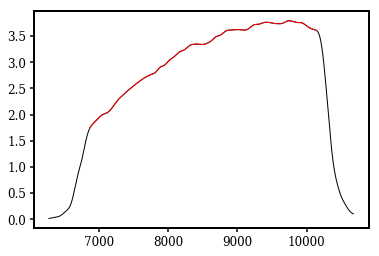

In [308]:
##
print('-------------------------------------Initial fit ---------------------------------------------------------------------------------------')
[x, y, y_err, wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod] = \
derive_1D_spectra_Av_corrected(OneD_1, redshift_1, row, wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod, A_v)
if redshift< 0.49:
    try:
        chi_square_list.loc[row,'grism_index'] = Lick_index_ratio(x,y)
    except:
        pass
# print(y)
# Testing fitting a line
photo_list_for_scaling = []
photo_err_list_for_scaling = []
grism_flux_list_for_scaling = []
grism_flux_err_list_for_scaling = []
grism_wave_list_for_scaling =[]
for i in range(len(wave_list)):
    if wave_list[i]-band_list[i] > x[0] and wave_list[i] + band_list[i] < x[-1]:
        scale_index = find_nearest(x, wave_list[i])
        photo_list_for_scaling.append(photometric_flux[i])
        photo_err_list_for_scaling.append(photometric_flux_err[i])
        grism_flux_list_for_scaling.append(y[scale_index])
        grism_flux_err_list_for_scaling.append(y_err[scale_index])
        grism_wave_list_for_scaling.append(x[scale_index])
photo_array_for_scaling = np.array(photo_list_for_scaling)
photo_err_array_for_scaling = np.array(photo_err_list_for_scaling)
grism_flux_array_for_scaling = np.array(grism_flux_list_for_scaling)
grism_flux_err_array_for_scaling = np.array(grism_flux_err_list_for_scaling)
grism_wave_array_for_scaling = np.array(grism_wave_list_for_scaling)
print('Number of photometric points for rescaling:',len(photo_array_for_scaling))
print(np.mean(photo_array_for_scaling/grism_flux_array_for_scaling))
coeff = np.mean(photo_array_for_scaling/grism_flux_array_for_scaling)
y = y*coeff

### 1 Test M05 model

In [309]:
# Test with M05 models
print('____________________M05_________________________ Optimization__________________________')
X = np.array([galaxy_age, intrinsic_Av])
bnds = ((0.01, 13.0), (0.0, 4.0))
sol = optimize.minimize(minimize_age_AV_vector_weighted, X, bounds = bnds, method='TNC')#, options = {'disp': True})
# print('Optimized weighted reduced chisqure result:', sol)
[age_prior_optimized, AV_prior_optimized] = sol.x
X = sol.x
print(X)
x2_optimized = minimize_age_AV_vector_weighted(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_return_chi2_sep(X)
chi_square_list.loc[row,'M05_age_opt'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M05_AV_opt'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M05_opt'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M05_opt'] = x2_spec
chi_square_list.loc[row,'x2_photo_M05_opt'] = x2_phot


____________________M05_________________________ Optimization__________________________
[1.59331773 0.44110488]


[1.59331773 0.44110488]


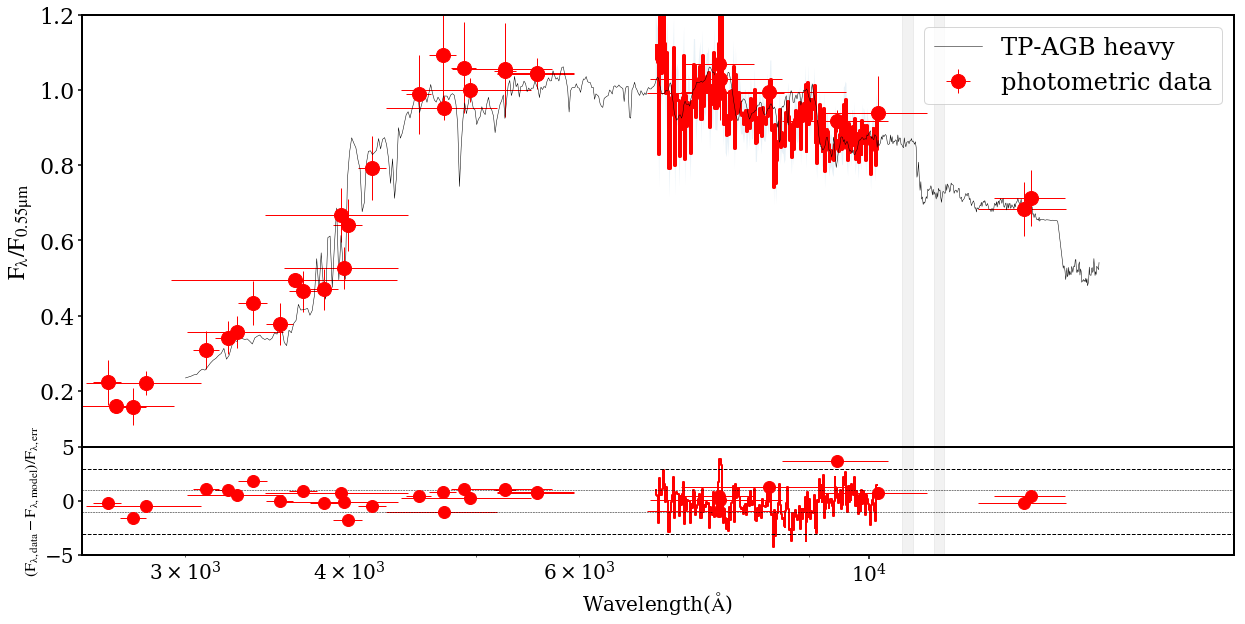

In [310]:
#--- Plot
X=sol.x
print(X)
n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err_mod, color='r', fmt='o', label='photometric data', markersize='14')
model_wave =minimize_age_AV_vector_weighted_return_flux(X)[1]
model_flux =minimize_age_AV_vector_weighted_return_flux(X)[2]
plt.plot(model_wave, model_flux, color='k',label='TP-AGB heavy',lw=0.5)
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.2])#plt.ylim([ymin,ymax])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0, :index0], color='r', linewidth=2)
# print(relative_sigma[0, :index0])
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err_mod[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
# plt.ylim([0.6,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)

plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

In [21]:
nsteps=3000
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    p0 = [sol.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted, pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    print(np.size(samples))
    samples = samples[(samples[:,0] > age_prior_optimized*0.1) & (samples[:,0] < age_prior_optimized*2.0) & (samples[:,1] < AV_prior_optimized*3.0)]
    tok = time.clock()
    multi_time = tok-tik
    print(np.size(samples))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print('Time to run M05 MCMC:'+str(tok-tik)) 
    print('sample size:',samples.size)       

100%|██████████| 3000/3000 [08:16<00:00,  6.04it/s]


50000
23382
Multiprocessing took 15.6 seconds
Time to run M05 MCMC:15.5591
sample size: 23382


<Figure size 3200x3200 with 0 Axes>

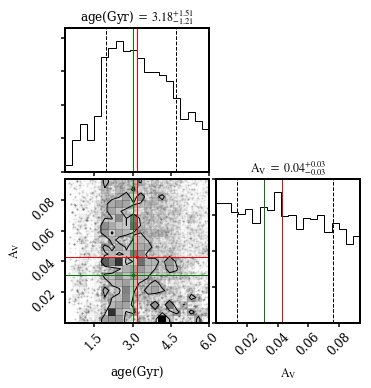

In [22]:
if samples.size > 1e3:
    value2 = np.percentile(samples, 50, axis=0)
    [std_age_prior_optimized, std_AV_prior_optimized] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
         labels=["age(Gyr)", r"$\rm A_V$"],
         truths=[age_prior_optimized, AV_prior_optimized],
         levels = (1-np.exp(-0.5),),
         # range=[(0.01, 13.0), (0.0, 4.0)],
         show_titles=True,title_kwargs={'fontsize':12},
                        quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})

Text(0.5, 0, 'Wavelength($\\rm \\AA$)')

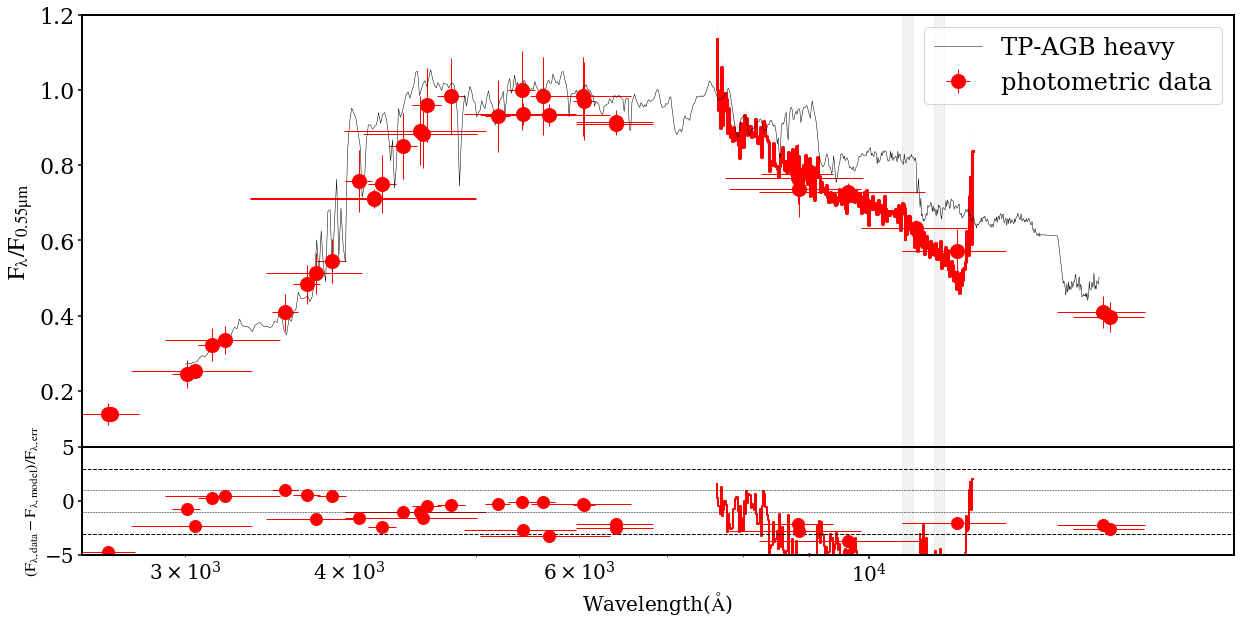

In [30]:
X = np.percentile(samples, 50, axis=0)
x2_optimized = minimize_age_AV_vector_weighted(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_return_chi2_sep(X)
chi_square_list.loc[row,'M05_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M05_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M05_MCMC50'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M05_MCMC50'] = x2_spec
chi_square_list.loc[row,'x2_photo_M05_MCMC50'] = x2_phot
chi_square_list.loc[row,'M05_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
chi_square_list.loc[row,'M05_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])

n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err_mod, color='r', fmt='o', label='photometric data', markersize='14')
model_wave =minimize_age_AV_vector_weighted_return_flux(X)[1]
model_flux =minimize_age_AV_vector_weighted_return_flux(X)[2]
plt.plot(model_wave, model_flux, color='k',label='TP-AGB heavy',lw=0.5)
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.2])#plt.ylim([ymin,ymax])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
plt.step(x[:index0], relative_sigma[0, :index0], color='r', linewidth=2)
# print(relative_sigma[0, :index0])
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err_mod[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)


### 2 Test with M13 models

In [23]:
# Test with the new M13 models
print('____________________M13_________________________ Optimization__________________________')
bnds = ((0.0, 13.0), (0.0, 4.0))
X = np.array([galaxy_age, intrinsic_Av])
sol_M13 = optimize.minimize(minimize_age_AV_vector_weighted_M13, X, bounds = bnds, method='TNC')#, options = {'disp': True})
# print('Optimized M13 weighted reduced chisqure result:', sol_M13)
[age_prior_optimized_M13, AV_prior_optimized_M13] = sol_M13.x
X = sol_M13.x
x2_optimized = minimize_age_AV_vector_weighted_M13(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_M13_return_chi2_sep(X)
chi_square_list.loc[row,'M13_age_opt'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M13_AV_opt'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M13_opt'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M13_opt'] = x2_spec
chi_square_list.loc[row,'x2_photo_M13_opt'] = x2_phot

____________________M13_________________________ Optimization__________________________


Text(0.5, 0, 'Wavelength($\\rm \\AA$)')

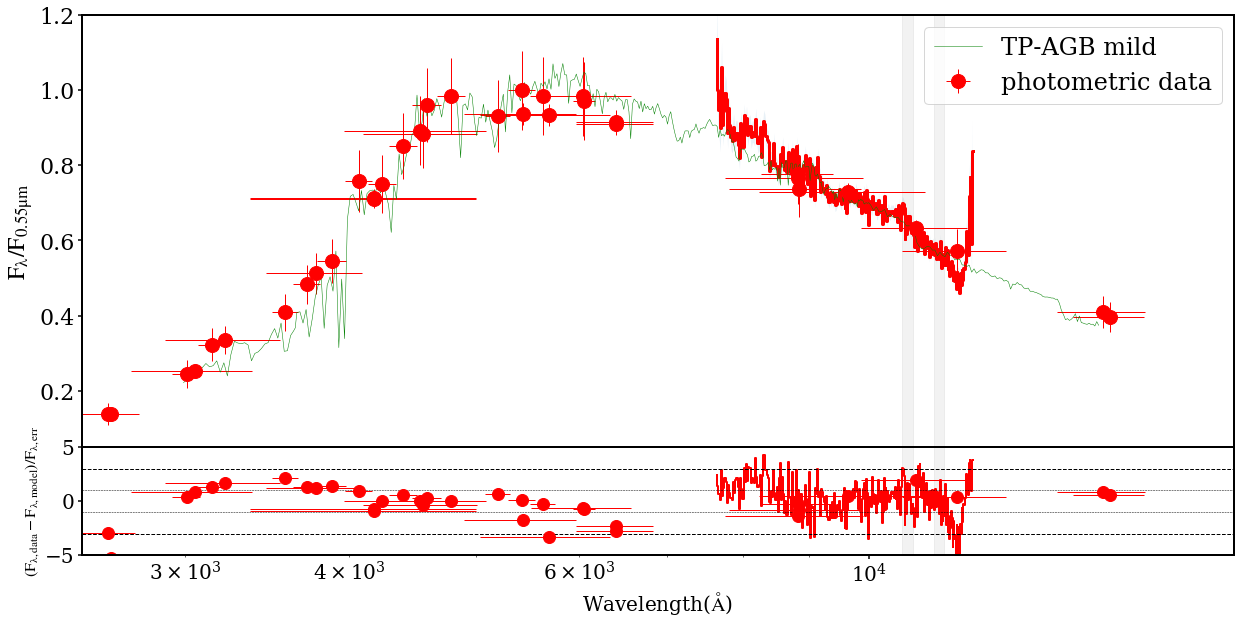

In [25]:
#--- Plot
X = sol_M13.x
n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err_mod, color='r', fmt='o', label='photometric data', markersize='14')
model_wave =minimize_age_AV_vector_weighted_M13_return_flux(X)[1]
model_flux =minimize_age_AV_vector_weighted_M13_return_flux(X)[2]
plt.plot(model_wave, model_flux, color='g',label='TP-AGB mild',lw=0.5)
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.2])#plt.ylim([ymin,ymax])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
plt.step(x[:index0], relative_sigma[0, :index0], color='r', linewidth=2)
# print(relative_sigma[0, :index0])
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err_mod[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
# plt.ylim([0.75,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

In [26]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    p0 = [sol_M13.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted_M13, pool=pool)
    sampler.run_mcmc(p0,nsteps, progress=True)
    print(np.size(samples))

    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized_M13*0.1) & (samples[:,0] < age_prior_optimized_M13*2.0) & (samples[:,1] < AV_prior_optimized_M13*3.0)]
    print(np.size(samples))

    tok = time.clock()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print('Time to run M13 MCMC:'+str(tok-tik))

100%|██████████| 3000/3000 [04:41<00:00, 10.66it/s]

23382
31176
Multiprocessing took 11.4 seconds
Time to run M13 MCMC:11.381591


<Figure size 3200x3200 with 0 Axes>

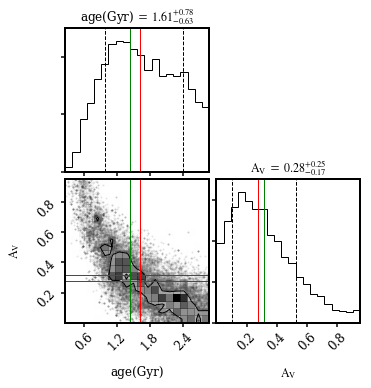

In [27]:
if samples.size > 1e3 :
    value2=np.percentile(samples, 50, axis=0)
    [std_age_prior_optimized_M13, std_AV_prior_optimized_M13] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
         labels=["age(Gyr)", r"$\rm A_V$"],
         levels=(1-np.exp(-0.5),),
         truths=[age_prior_optimized_M13, AV_prior_optimized_M13],
         show_titles=True,title_kwargs={'fontsize':12},
                        quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
    # Loop over the histograms
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})

Text(0.5, 0, 'Wavelength($\\rm \\AA$)')

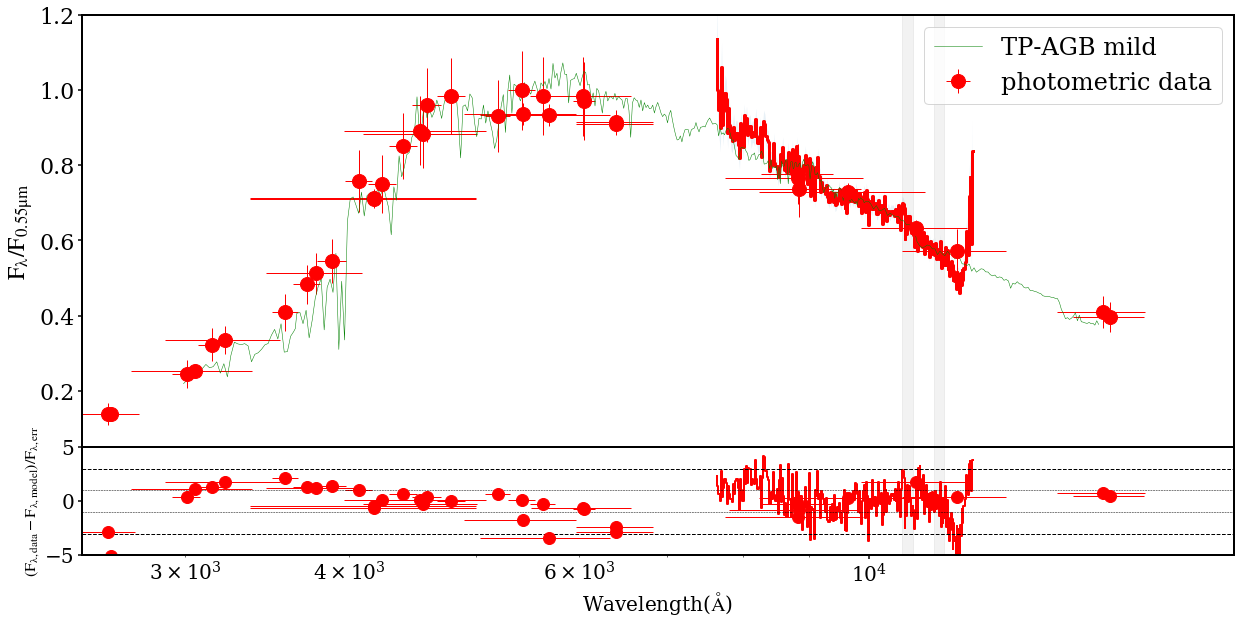

In [31]:
#--- Plot
X = np.percentile(samples, 50, axis=0)
x2_optimized = minimize_age_AV_vector_weighted_M13(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_M13_return_chi2_sep(X)
chi_square_list.loc[row,'M13_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M13_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M13_MCMC50'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M13_MCMC50'] = x2_spec
chi_square_list.loc[row,'x2_photo_M13_MCMC50'] = x2_phot
chi_square_list.loc[row,'M13_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
chi_square_list.loc[row,'M13_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])            
n = len(x)

fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err_mod, color='r', fmt='o', label='photometric data', markersize='14')
model_wave =minimize_age_AV_vector_weighted_M13_return_flux(X)[1]
model_flux =minimize_age_AV_vector_weighted_M13_return_flux(X)[2]
plt.plot(model_wave, model_flux, color='g',label='TP-AGB mild',lw=0.5)
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.2])#plt.ylim([ymin,ymax])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err_mod[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
# plt.ylim([0.75,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

### 3 BC03 model

In [24]:
print('____________________BC03_________________________ Optimization__________________________')
bnds = ((0.0, 13.0), (0.0, 4.0))
X = np.array([galaxy_age,intrinsic_Av])
sol_BC03 = optimize.minimize(minimize_age_AV_vector_weighted_BC03, X, bounds = bnds, method='TNC')#, options = {'disp': True})
# print('Optimized BC03 weighted reduced chisqure result:', sol_BC03)
[age_prior_optimized_BC03, AV_prior_optimized_BC03] = sol_BC03.x
X = sol_BC03.x
x2_optimized = minimize_age_AV_vector_weighted_BC03(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_BC03_return_chi2_sep(X)
chi_square_list.loc[row,'BC_age_opt'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'BC_AV_opt'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_BC_opt'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_BC_opt'] = x2_spec
chi_square_list.loc[row,'x2_photo_BC_opt'] = x2_phot

____________________BC03_________________________ Optimization__________________________
1.584893192461111 1.60899994
1.584893192461111 1.60899994
1.5848932024611109 1.60899994
1.584893192461111 1.60899994
1.584892944734361 1.60899994
1.584892944734361 1.60899994
1.5848929547343609 1.60899994
1.584892944734361 1.60899994
1.3520868317761394 1.27809997
1.3520868317761394 1.27809997
1.3520868417761394 1.27809997
1.3520868317761394 1.27809997
1.3520868310483074 1.27809997
1.3520868310483074 1.27809997
1.3520868410483073 1.27809997
1.3520868310483074 1.27809997
1.3469997840170898 1.27809997
1.3469997840170898 1.27809997
1.3469997940170897 1.27809997
1.3469997840170898 1.27809997
1.3215645452218414 1.27809997
1.3215645452218414 1.27809997
1.3215645552218414 1.27809997
1.3215645452218414 1.27809997
1.3342821646194665 1.27809997
1.3342821646194665 1.27809997
1.3342821746194664 1.27809997
1.3342821646194665 1.27809997
1.3406409743182781 1.27809997
1.3406409743182781 1.27809997
1.340640984318278

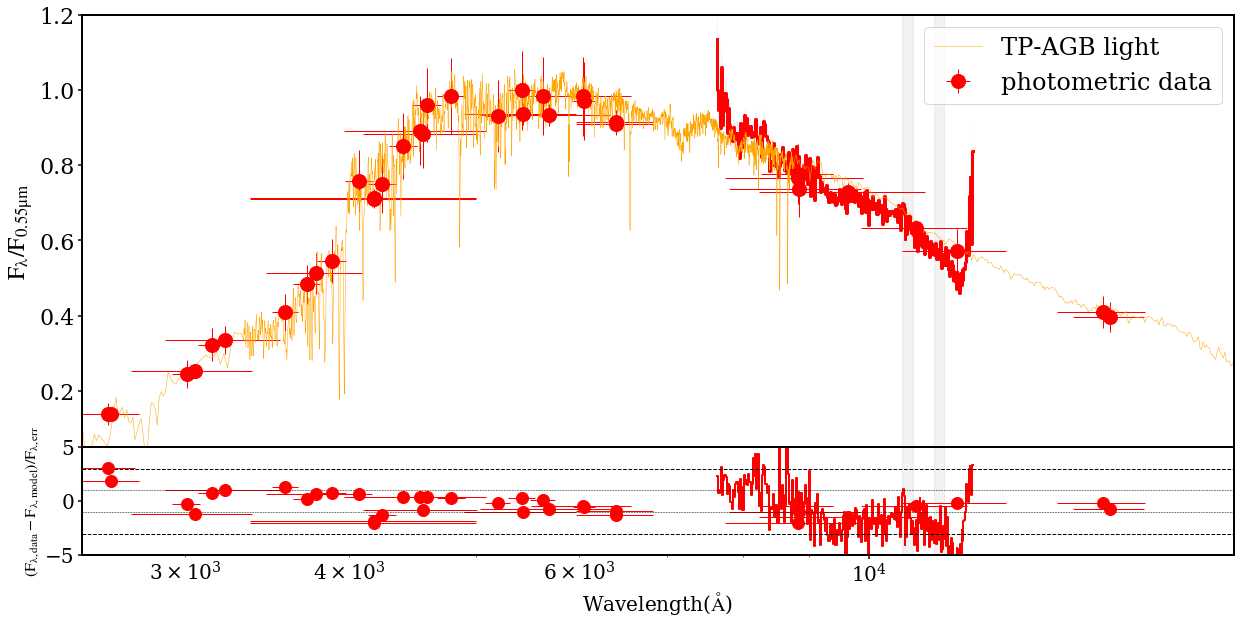

In [32]:
#--- Plot
X = sol_BC03.x
n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err_mod, color='r', fmt='o', label='photometric data', markersize='14')
BC03_flux_attenuated = minimize_age_AV_vector_weighted_BC03_mod_no_weight_return_flux(X)[1]
plt.plot(BC03_wave_list_num, BC03_flux_attenuated, color='orange',label='TP-AGB light',lw=0.5)
model_wave = BC03_wave_list_num
model_flux = BC03_flux_attenuated
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.2])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0, :index0], color='r', linewidth=2)
# print(relative_sigma[0, :index0])
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err_mod[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
# plt.ylim([0.6,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)

plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

In [28]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    p0 = [sol_BC03.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted_BC03, pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)
    print(np.size(samples))

    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized_BC03*0.1) & (samples[:,0] < age_prior_optimized_BC03*2.0) & (samples[:,1] < AV_prior_optimized_BC03*3.0)]
    print(np.size(samples))

    tok = time.clock()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print('Time to run BC03 MCMC:'+str(tok-tik))

100%|██████████| 3000/3000 [16:16<00:00,  3.07it/s]

31176
41632
Multiprocessing took 16.2 seconds
Time to run BC03 MCMC:16.156475


<Figure size 3200x3200 with 0 Axes>

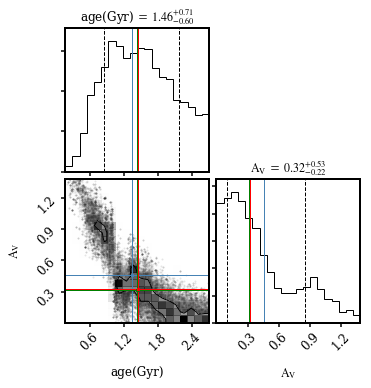

In [29]:
if samples.size > 1e3:
    value2=np.percentile(samples,50,axis=0)
    [std_age_prior_optimized_BC03, std_AV_prior_optimized_BC03] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
                        labels=["age(Gyr)", r"$\rm A_V$"],\
                        truths=[age_prior_optimized_BC03, AV_prior_optimized_BC03],\
                        levels = (1-np.exp(-0.5),),\
                        show_titles=True,title_kwargs={'fontsize':12},
                        quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})

1.4574269488774614 1.434


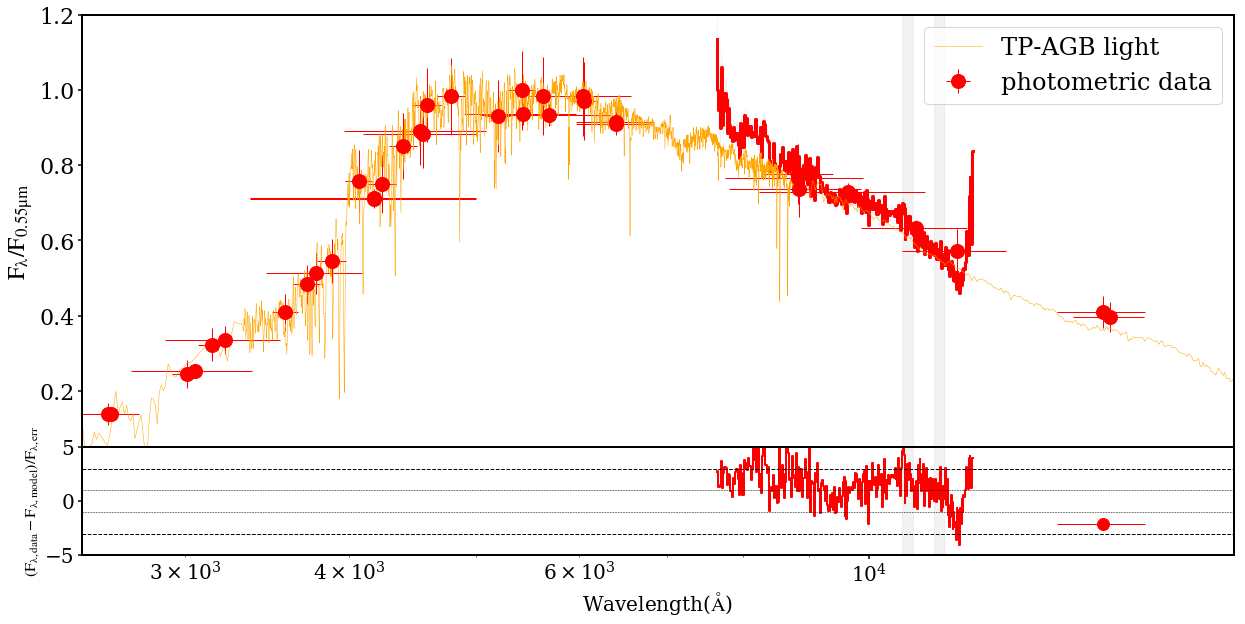

In [33]:
#--- Plot
X = np.percentile(samples, 50, axis=0)
x2_optimized = minimize_age_AV_vector_weighted_BC03(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_BC03_return_chi2_sep(X)
chi_square_list.loc[row,'BC_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'BC_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_BC_MCMC50'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_BC_MCMC50'] = x2_spec
chi_square_list.loc[row,'x2_photo_BC_MCMC50'] = x2_phot
chi_square_list.loc[row,'BC_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
chi_square_list.loc[row,'BC_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])
n = len(x)

fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err_mod, color='r', fmt='o', label='photometric data', markersize='14')
BC03_flux_attenuated = minimize_age_AV_vector_weighted_BC03_mod_no_weight_return_flux(X)[1]
plt.plot(BC03_wave_list_num, BC03_flux_attenuated, color='orange',label='TP-AGB light',lw=0.5)
model_wave = BC03_wave_list_num
model_flux = BC03_flux_attenuated            
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.2])#plt.ylim([ymin,ymax])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err_mod[i], xerr=band_list[i], fmt='o', color='r', markersize=12)

index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
# plt.ylim([0.6,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

### 4 Determine the best-fit model

In [35]:
chi2_array=chi_square_list.loc[row,['x2_M05_opt','x2_M13_opt','x2_BC_opt','x2_M05_MCMC50','x2_M13_MCMC50','x2_BC_MCMC50']].values
AV_array=chi_square_list.loc[row,['M05_AV_opt','M13_AV_opt','BC_AV_opt','M05_AV_MCMC50','M13_AV_MCMC50','BC_AV_MCMC50']].values
index = find_nearest(chi2_array,0)
model = np.mod(index,3)+1
print(chi2_array)
print(model)

[1.1221263707184084 1.1068419395927145 0.7305873242887877
 9.552096407889755 1.1132833837826859 0.7786680397402593]
3


### 5 Calculate the flux ratio

In [36]:
AV_opt = float(AV_array[index])
spectra_extinction = calzetti00(x, AV_opt, 4.05)
spectra_flux_correction = 10 ** (-0.4 * spectra_extinction)
y_corr = y / spectra_flux_correction

if redshift<0.49:
    try:
        chi_square_list.loc[row,'grism_index_AV_corr'] = Lick_index_ratio(x,y_corr)
        print('Measured CN index with AV correction',Lick_index_ratio(x,y_corr))
    except:
        pass 

Measured CN index with AV correction 1.1721174679352198


### 6 Test with photometry filter sets

f1_Paranal_VIMOS.U.dat.txt
258
f2_Paranal_VIMOS.R.dat.txt
468
f5_843.dat
504
f6_844.dat
1450
f9_SubIB445.res.txt
966
f12_SubIB550.res.txt
602
f14_SubIB598.res.txt
1598
f16_SubIB651.res.txt
720
f20_SubIB797.res.txt
784
f21_SubIB856.res.txt
282
f25_HST_ACS_HRC.F850LP.dat.txt
6384
f27_ACS_F814W.res.txt
626
f28_HST_ACS_HRC.F850LP.dat.txt
6384
f29_HST_WFC3_IR.F125W.dat.txt
2220
f30_HST_WFC3_IR.F140W.dat.txt
1482
f31_HST_WFC3_IR.F160W.dat.txt
1148
f35_J_wfcam.res.txt
472


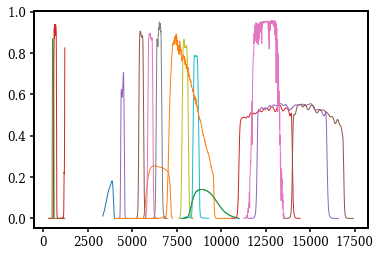

In [85]:
filter_fn_list = []
path = "/Volumes/My Passport/TAPS/filter/goodss/"
import glob, os
os.chdir(path)
for i in index_list:
    for file in glob.glob("f"+str(i)+"_*"):
        print(file)
        fn = path+file
        filter_fn_list.append(fn)
# filter_fn_list[0]
    filter_curve = np.loadtxt(fn,skiprows=n)
    print(filter_curve.size)#[:,0]
    plt.plot(filter_curve[:,0],filter_curve[:,1])

In [39]:
model_wave = BC03_wave_list_num
model_flux = BC03_flux_attenuated


1 f1_Paranal_VIMOS.U.dat.txt
3666.4 0.4409380486450508
2 f2_Paranal_VIMOS.R.dat.txt
6429.41 0.9329711928688388
5 f5_843.dat
542.5 0.001057718585707289
6 f6_844.dat
736.5 0.0024261690879195446
9 f9_SubIB445.res.txt
4457.0 0.9414156204156165
12 f12_SubIB550.res.txt
5500.0 0.972675669077779
14 f14_SubIB598.res.txt
5999.0 0.9594374525671295
16 f16_SubIB651.res.txt
6518.0 0.9251583697673266
20 f20_SubIB797.res.txt
7992.0 0.8152143053042669
21 f21_SubIB856.res.txt
8600.0 0.7812559395865412
25 f25_HST_ACS_HRC.F850LP.dat.txt
9329.0 0.5732778903174439
27 f27_ACS_F814W.res.txt
8380.0 0.8128981872345926
28 f28_HST_ACS_HRC.F850LP.dat.txt
9329.0 0.5732778903174439
29 f29_HST_WFC3_IR.F125W.dat.txt
12490.0 0.4801639562381347
30 f30_HST_WFC3_IR.F140W.dat.txt
14043.837890625 0.4214572416304399
31 f31_HST_WFC3_IR.F160W.dat.txt
15444.21875 0.37548200554179084
35 f35_J_wfcam.res.txt
12430.0 0.48142299292852836


Text(0.5, 0, 'Wavelength($\\rm \\AA$)')

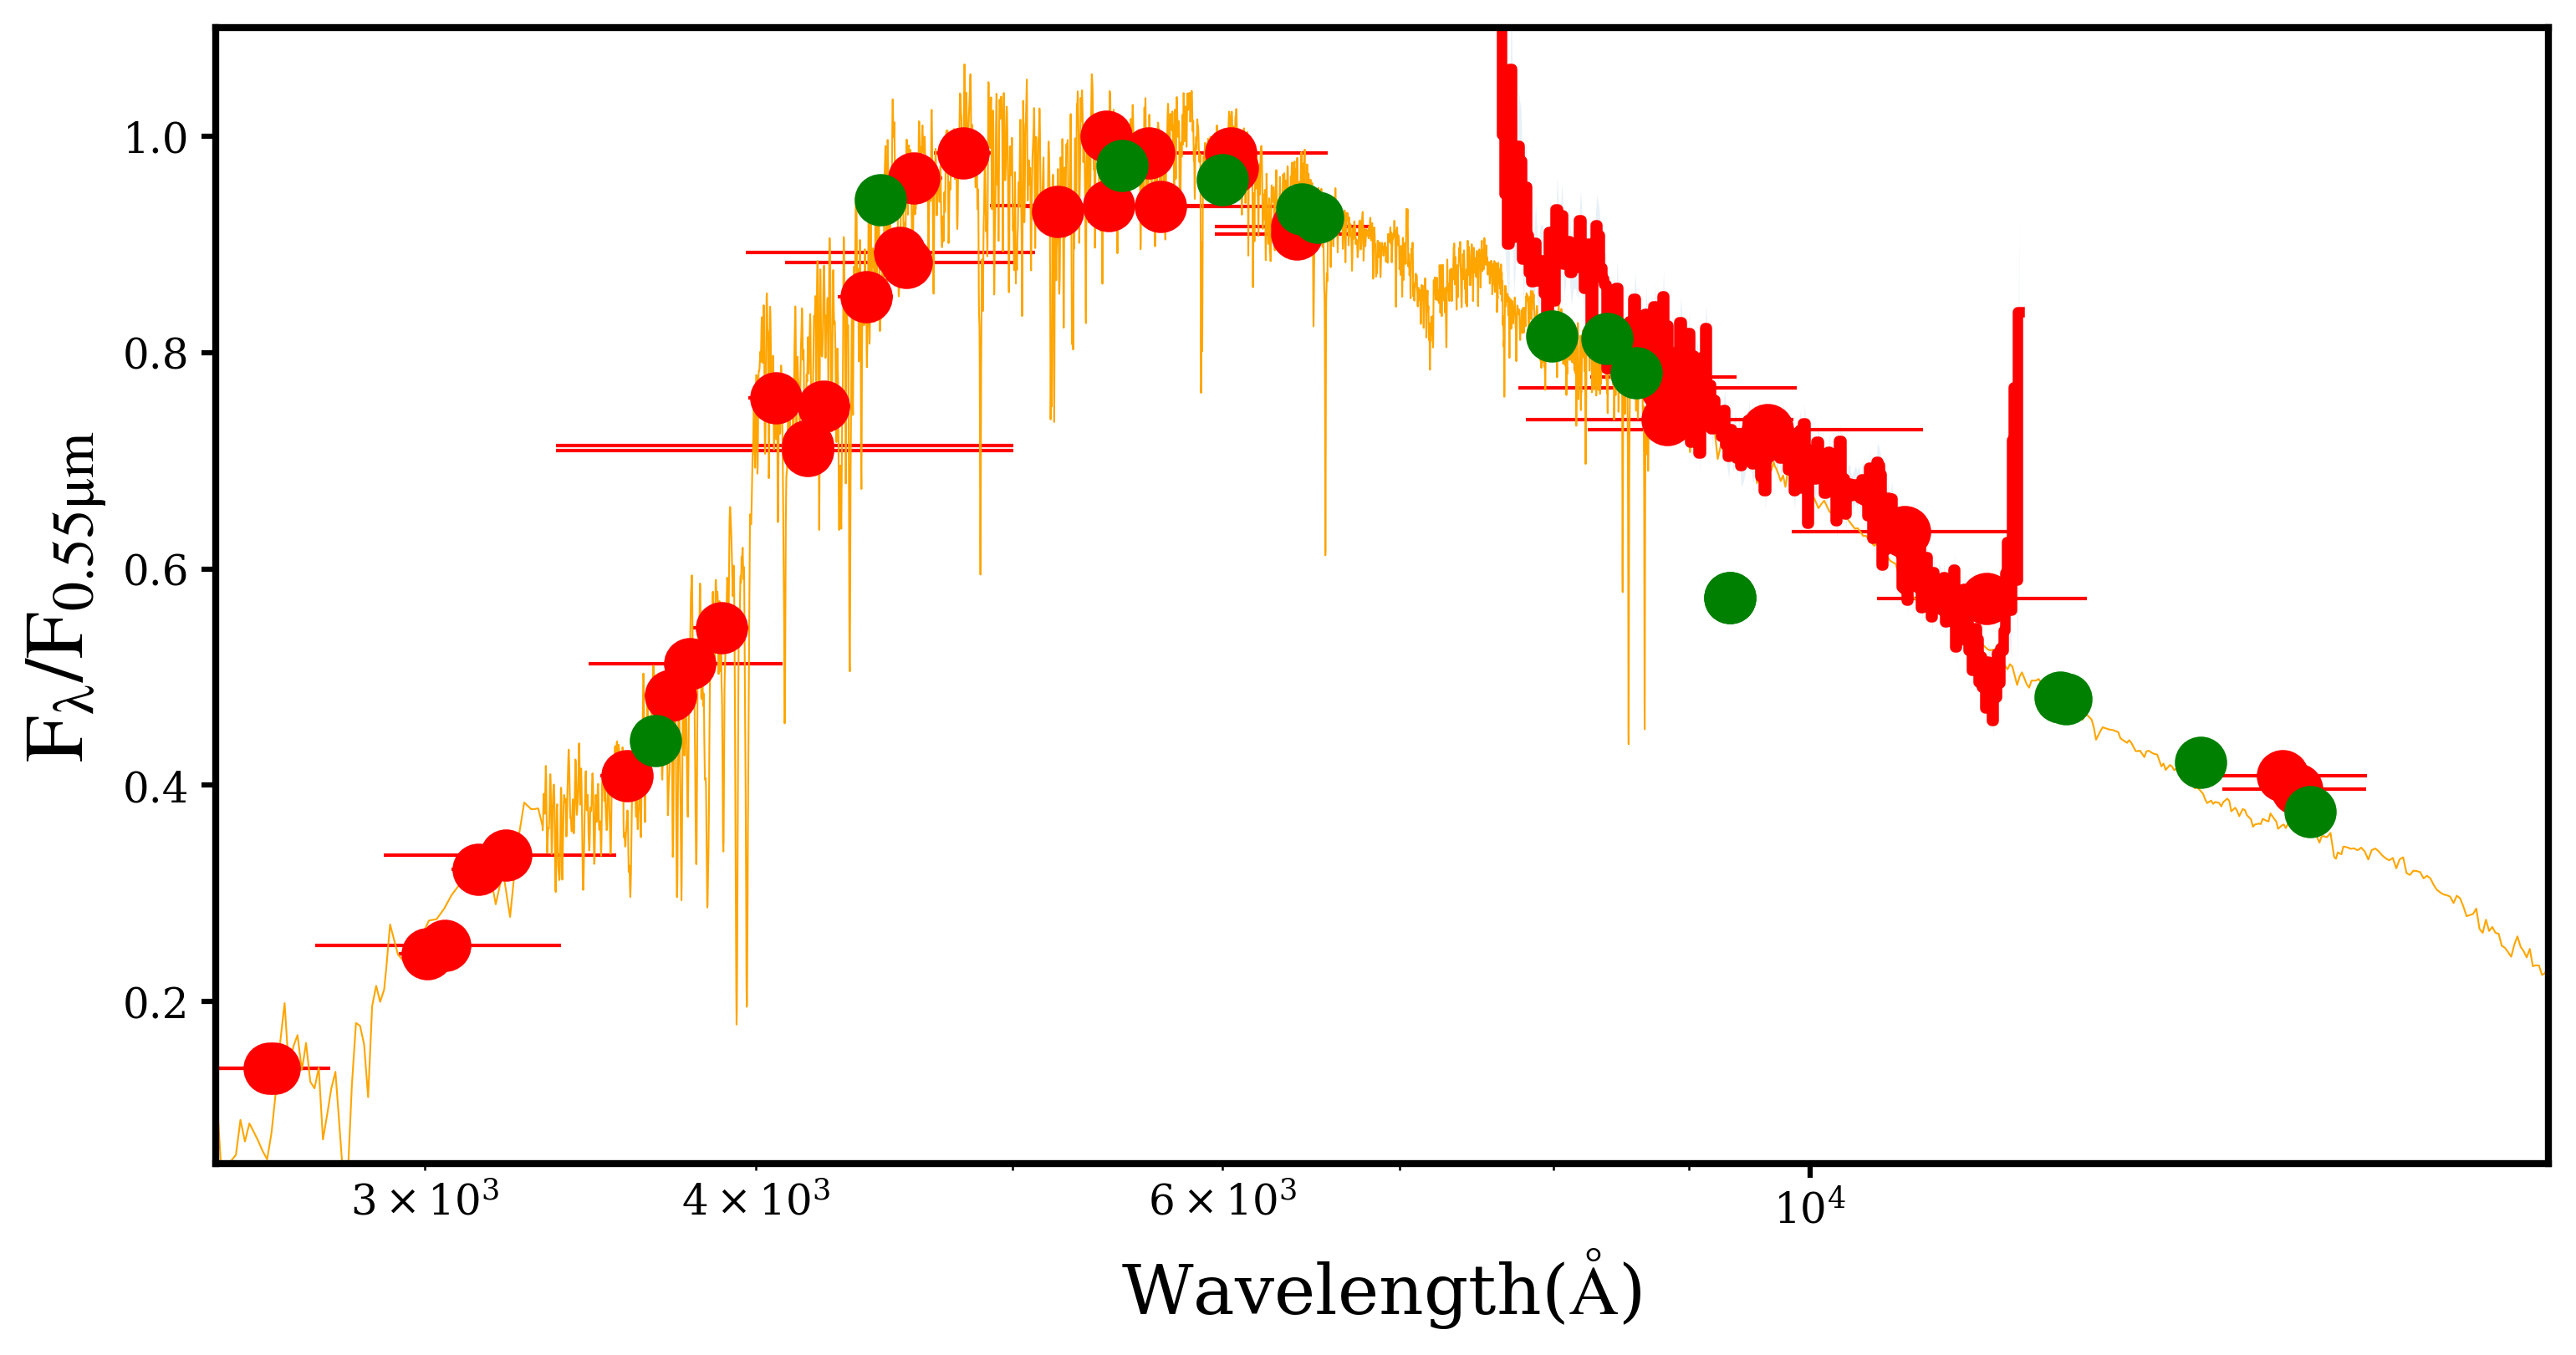

In [80]:
filter_fn_list = []
path = "/Volumes/My Passport/TAPS/filter/goodss/"
photometry_list = np.zeros(36)
import glob, os
os.chdir(path)
plt.figure(figsize=(12,6),dpi=300)
plt.plot(model_wave, model_flux, color='orange',lw=0.5)

plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])
plt.semilogx()
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)

plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err, color='r', fmt='o', label='photometric data', markersize='14')

os.chdir(path)
index_list = [1,2,5,6,9,12,14,16,20,21,25,27,28,29,30,31,35]
for i in index_list:
    for file in glob.glob("f"+str(i)+"_*"):
        print(i,file)
        fn = path+file
        filter_fn_list.append(fn)
        filter_curve = np.loadtxt(fn)#,comments='#')
#     print(filter_curve.size)#[:,0]
    sum_flambda_AB_K = 0
    length = 0
    for j in range(len(filter_curve)-1):
        index = np.where(model_wave<filter_curve[j+1,0])[0]#[0]
        wave = model_wave[index]
        flux = model_flux[index]
        index = np.where(wave>filter_curve[j,0])
        wave = wave[index]
        flux = flux[index]
        n = len(flux)
#         print(n)
        if n!= 0 and n!=1:
            flambda_AB_K = np.trapz(flux, x=wave)*filter_curve[j,1]/(np.trapz(np.ones(n), x=wave)*filter_curve[j,1])#/2.99792458e16#/np.trapz(np.ones(n)*transmission[i], x=wave)
#             print(j,n,flambda_AB_K, np.trapz(flux, x=wave)*filter_curve[j,1])
            sum_flambda_AB_K += flambda_AB_K
            length = length+1
#             plt.plot(filter_curve[:,0],filter_curve[:,1])
        elif n==1:
            flambda_AB_K = flux
            sum_flambda_AB_K += flambda_AB_K
            length = length+1
#     print('photo',sum_flambda_AB_K, n, length)#, wave[int(n/2)])
    photometry_list[i-1] = sum_flambda_AB_K/length
    plt.errorbar(filter_curve[int(len(filter_curve)/2),0],photometry_list[i-1], color='g', fmt='o',  markersize=14)
    print(filter_curve[int(len(filter_curve)/2),0],photometry_list[i-1])
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)


In [81]:
def reduced_chi_square_photo(data_wave,data,data_err,model):
    n=len(data_wave)
    chi_square = 0
    for i in range(n):
        index = find_nearest(model_wave,data_wave[i]);#print index
#         chi_square += (data[i]-model[index])**2/(data_err[i]**2)
        chi_square += (data[i]-model[i])**2/(data_err[i]**2)
        print('chisquare processes',i,chi_square, data_wave[i], data[i],data_err[i],model[i])
    reduced_chi_square = chi_square/n
    return reduced_chi_square

In [82]:

reduced_chi_square_photo(wave_list[index_list],photometric_flux[index_list],\
                         photometric_flux_err_mod[index_list],photometry_list)

chisquare processes 0 24.562804375594627 4558.09187279152 0.8832529978973637 0.08924679793019336 0.4409380486450508
chisquare processes 1 810.5338248037145 2619.0812720848057 0.13837513583873157 0.028342825238252555 0.9329711928688388
chisquare processes 2 905.8730062741928 4530.7420494699645 0.8926021223874594 0.09141599816469408 0.0
chisquare processes 3 993.6397690100428 6045.229681978798 0.9841069779208873 0.10504545616426543 0.0
chisquare processes 4 1062.5722423147329 3575.2650176678444 0.40864685566360676 0.04909199374054181 0.001057718585707289
chisquare processes 5 1146.7756656683155 4070.6713780918726 0.7580794346213049 0.08234887856192306 0.0024261690879195446
chisquare processes 6 1239.9173307050276 4400.706713780919 0.8512254560044578 0.08820081621502777 0.0
chisquare processes 7 1335.326414078078 4790.106007067137 0.984762513469219 0.10081766772089544 0.0
chisquare processes 8 1335.406802857969 6050.883392226148 0.9709330996010456 0.10410738720669341 0.9414156204156165
ch

298.349596115508

In [83]:
print(photometry_list[index_list])

[0.93297119 0.         0.00242617 0.         0.         0.
 0.         0.         0.78125594 0.         0.         0.57327789
 0.48016396 0.42145724 0.37548201 0.         0.        ]
